In [14]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns

import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_theme()

In [15]:
# Let's define some neural networks

# First up a simple feedforward network, with some hidden layers and 
# a sigmoid activation in the end to restrict the ouput between 0 and 1

class MLP(nn.Module):
    def __init__(self,  trajectory_length, N_spins, input_size, hidden_size, batch_size=64):
        super(MLP, self).__init__()
        
        self.activation = nn.ReLU()

        modules = []

        modules.append(nn.Linear(N_spins * 1, 128))
        modules.append(self.activation)
        modules.append(nn.Dropout(0.1))
        modules.append(nn.Linear(128, batch_size))
        modules.append(self.activation)
        modules.append(nn.Dropout(0.1))
        modules.append(nn.Linear(batch_size, hidden_size))
        modules.append(self.activation)
        modules.append(nn.Dropout(0.1))
        self.net = nn.Sequential(*modules)

        modules = []
        modules.append(nn.Linear(trajectory_length * hidden_size, 1))
        modules.append(nn.Sigmoid())
        self.netout = nn.Sequential(*modules)

    def forward(self, X):   

        X = self.net(X)

        X = X.reshape(X.shape[0], -1)

        return self.netout(X)



# secondly a VERY simple convolutional network with a 3x3 filter reducing 
# the frames (channels) and a linear layer for the output

class CNN(nn.Module):
    def __init__(self, trajectory_length, N_spins, N_channels_hidden = 10):
        super(CNN, self).__init__()
        
        self.activation = nn.ReLU()

        modules_cnn = []

        modules_cnn.append(nn.Conv1d(trajectory_length, N_channels_hidden, 3))
        modules_cnn.append(self.activation)
        modules_cnn.append(nn.Dropout(0.1))

        modules_cnn.append(nn.Conv1d(N_channels_hidden, 1, 3))
        modules_cnn.append(self.activation)
        modules_cnn.append(nn.Dropout(0.1))


        modules_linear = []
        modules_linear.append(nn.Linear((N_spins)*(1)-4, 1))
        modules_linear.append(nn.Sigmoid())


        self.net = nn.Sequential(*modules_cnn)
        self.linear_net = nn.Sequential(*modules_linear)

    def forward(self, X):

        X = self.net(X)

        X = X.reshape(X.shape[0], X.shape[2])
        
        return self.linear_net(X)

In [16]:
def readData(directory, BJ, N_spins):
    filter_string = f'500-{BJ}-{N_spins}'
    dfs = []
    count = 0
    # training_data
    for filename in os.listdir(directory):
        
        if filename.endswith('.csv') and filter_string in filename:
            # load the CSV file into a pandas DataFrame
            p = os.path.join(directory,filename)
            try:
                df = pd.read_csv(p,sep=';', decimal=",", header=None, skiprows=1)
            except:
                pass
            # do something with the DataFrame
            if len(df) != 500:
                continue
            dfs.append(df)
            
            count +=1
            if count == 500:
                break

    return dfs

In [17]:
def createDataArray(num_files, N_spins, dfs):
    data = np.zeros((num_files,500,N_spins,1))

    for trajectory_index in range(0,len(dfs)):
        for iteration_index in range(500):
            obj = np.array(dfs[trajectory_index].loc[iteration_index,4].split(',')).reshape((N_spins,1))
            for line in range(10):
                for row in range(1):
                            data[trajectory_index,iteration_index,line,row] = float(obj[line,row])
    trajectories_numpy_raw = data.reshape(-1, 500, N_spins*1)#np.random.normal(size=(100, 500, 32, 32)

    return trajectories_numpy_raw

In [18]:
def flipRandomBits(trajectories_numpy_raw):
    toFlip = np.random.choice([0,1], size=trajectories_numpy_raw.shape[0]).astype(bool)

    # flip
    trajectories_numpy = trajectories_numpy_raw.copy()
    trajectories_numpy[toFlip] = np.flip(trajectories_numpy[toFlip], 1)

    # Create Labels
    labels_numpy = np.zeros(trajectories_numpy.shape[0]).reshape(-1,1)
    labels_numpy[toFlip == 0] = 1

    return trajectories_numpy, labels_numpy

In [19]:
def createDataset(trajectories_numpy,labels_numpy):
    # Convert to pytorch tensor
    trajectories_tensor = torch.from_numpy(trajectories_numpy.astype(np.float32))
    labels_tensor = torch.from_numpy(labels_numpy.astype(np.float32))
        # Create a dataset
    full_dataset = torch.utils.data.TensorDataset(trajectories_tensor, labels_tensor)

    # Split into test and training data
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [int(len(full_dataset) * 0.8), len(full_dataset) - int(len(full_dataset) * 0.8)])

    # Create a data loader for train and test sets
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
    test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

    return train_dl, test_dl

In [20]:
# Our train loop, very similar to the example on the pytorch website

def train_model(N_epochs, model, train_dataloader, test_dataloader):

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    loss_history = []
    for epoch in range(N_epochs):

        train_losses, test_losses = [], []

        for i, (data, labels) in enumerate(train_dataloader):
            
            optimizer.zero_grad()
            
            y_pred = model(data)

            loss = criterion(y_pred, labels )
            
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
        

        with torch.no_grad():
            
            accuracy = 0
            for i, (data, labels) in enumerate(test_dataloader):
                    
                y_pred = model(data)
                loss = criterion(y_pred, labels )

                accuracy += (y_pred.round() == labels).sum().item()
                
                test_losses.append(loss.item())

        accuracy /= len(test_dataloader.dataset)

        loss_history.append([np.average(train_losses), np.average(test_losses), accuracy])

        print("Epoch {:04d}/{}: Train Loss: {:.4f} | Test Loss: {:.4f}\tAcc.: {:.4f} ".format(epoch, N_epochs, np.average(train_losses), np.average(test_losses), accuracy))

    return np.array(loss_history)

In [21]:
def createAndTrainNetwork(directory, N_spins, BJ, N_hidden, N_embedding):
    dfs = readData(directory, BJ, N_spins)
    data = createDataArray(len(dfs), N_spins, dfs)
    trajectories_numpy, labels_numpy = flipRandomBits(data)
    train_dl, test_dl = createDataset(trajectories_numpy, labels_numpy)
    arr = []
    model = MLP(trajectory_length=500, N_spins=N_spins, input_size=2, hidden_size=N_hidden, batch_size=N_embedding)
    # train the model for 10 epochs
    loss_history = train_model(15, model=model, train_dataloader=train_dl, test_dataloader=test_dl)
    arr.append([loss_history[-1]])
    sorted_arr = sorted(arr, key=lambda x: x[-1])
    last_value = 0
    for s in sorted_arr[-1::]:
        print(s)
        last_value = s[-1][-1]
    sns.set_context("paper")
    mpl.rcParams.update({'font.size': 5})

    fig_size = (12 * 0.393701, 5 * 0.393701) # cm -> inch: 0.393701 

    fig, ax = plt.subplot_mosaic([["losses", "accuracy"]],
        
                                figsize = fig_size, dpi = 300,
                                )

    ax["losses"].plot(loss_history[:,0], label=f"Train Loss for {N_spins}x1 for BJ={BJ} for {N_hidden} hidden and {N_embedding} embedding")
    ax["losses"].plot(loss_history[:,1], label=f"Test Loss for {N_spins}x1 for BJ={BJ} for {N_hidden} hidden and {N_embedding} embedding"")

    ax["losses"].legend(frameon=False)
    ax["losses"].set_xlabel("Epoch")
    ax["losses"].set_ylabel("BCE Loss")


    ax["accuracy"].plot(loss_history[:,2])

    ax["accuracy"].set_ylim(0, 1)
    ax["accuracy"].set_xlabel("Epoch")
    ax["accuracy"].set_ylabel("Test Accuracy")
    with open("data.txt", "a") as myfile:
        myfile.write(f"{N_spins} {BJ} {N_hidden} {N_embedding} {last_value} \n")

Epoch 0000/15: Train Loss: 0.7002 | Test Loss: 0.6896	Acc.: 0.5143 
Epoch 0001/15: Train Loss: 0.6927 | Test Loss: 0.6913	Acc.: 0.4571 
Epoch 0002/15: Train Loss: 0.6881 | Test Loss: 0.6887	Acc.: 0.5143 
Epoch 0003/15: Train Loss: 0.6882 | Test Loss: 0.6869	Acc.: 0.5429 
Epoch 0004/15: Train Loss: 0.6878 | Test Loss: 0.6891	Acc.: 0.5429 
Epoch 0005/15: Train Loss: 0.6875 | Test Loss: 0.6983	Acc.: 0.5429 
Epoch 0006/15: Train Loss: 0.6906 | Test Loss: 0.6935	Acc.: 0.5429 
Epoch 0007/15: Train Loss: 0.6881 | Test Loss: 0.6919	Acc.: 0.5429 
Epoch 0008/15: Train Loss: 0.6889 | Test Loss: 0.7006	Acc.: 0.5429 
Epoch 0009/15: Train Loss: 0.6854 | Test Loss: 0.6892	Acc.: 0.5429 
Epoch 0010/15: Train Loss: 0.6869 | Test Loss: 0.6893	Acc.: 0.5429 
Epoch 0011/15: Train Loss: 0.6909 | Test Loss: 0.6930	Acc.: 0.5429 
Epoch 0012/15: Train Loss: 0.6894 | Test Loss: 0.6890	Acc.: 0.5429 
Epoch 0013/15: Train Loss: 0.6883 | Test Loss: 0.6898	Acc.: 0.5429 
Epoch 0014/15: Train Loss: 0.6859 | Test Loss: 0

C:\Users\paralysat\AppData\Local\Temp\ipykernel_33464\4136221874.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplot_mosaic([["losses", "accuracy"]],


Epoch 0000/15: Train Loss: 0.6942 | Test Loss: 0.6887	Acc.: 0.5143 
Epoch 0001/15: Train Loss: 0.6900 | Test Loss: 0.6917	Acc.: 0.5143 
Epoch 0002/15: Train Loss: 0.6923 | Test Loss: 0.6887	Acc.: 0.5143 
Epoch 0003/15: Train Loss: 0.6857 | Test Loss: 0.6906	Acc.: 0.5143 
Epoch 0004/15: Train Loss: 0.6956 | Test Loss: 0.6888	Acc.: 0.5143 
Epoch 0005/15: Train Loss: 0.6939 | Test Loss: 0.6911	Acc.: 0.5143 
Epoch 0006/15: Train Loss: 0.6899 | Test Loss: 0.6921	Acc.: 0.5143 
Epoch 0007/15: Train Loss: 0.6909 | Test Loss: 0.7008	Acc.: 0.5143 
Epoch 0008/15: Train Loss: 0.6894 | Test Loss: 0.6930	Acc.: 0.5429 
Epoch 0009/15: Train Loss: 0.6900 | Test Loss: 0.6896	Acc.: 0.4857 
Epoch 0010/15: Train Loss: 0.6892 | Test Loss: 0.6972	Acc.: 0.5143 
Epoch 0011/15: Train Loss: 0.6898 | Test Loss: 0.6968	Acc.: 0.4286 
Epoch 0012/15: Train Loss: 0.6843 | Test Loss: 0.6927	Acc.: 0.4571 
Epoch 0013/15: Train Loss: 0.6924 | Test Loss: 0.6942	Acc.: 0.4571 
Epoch 0014/15: Train Loss: 0.6934 | Test Loss: 0

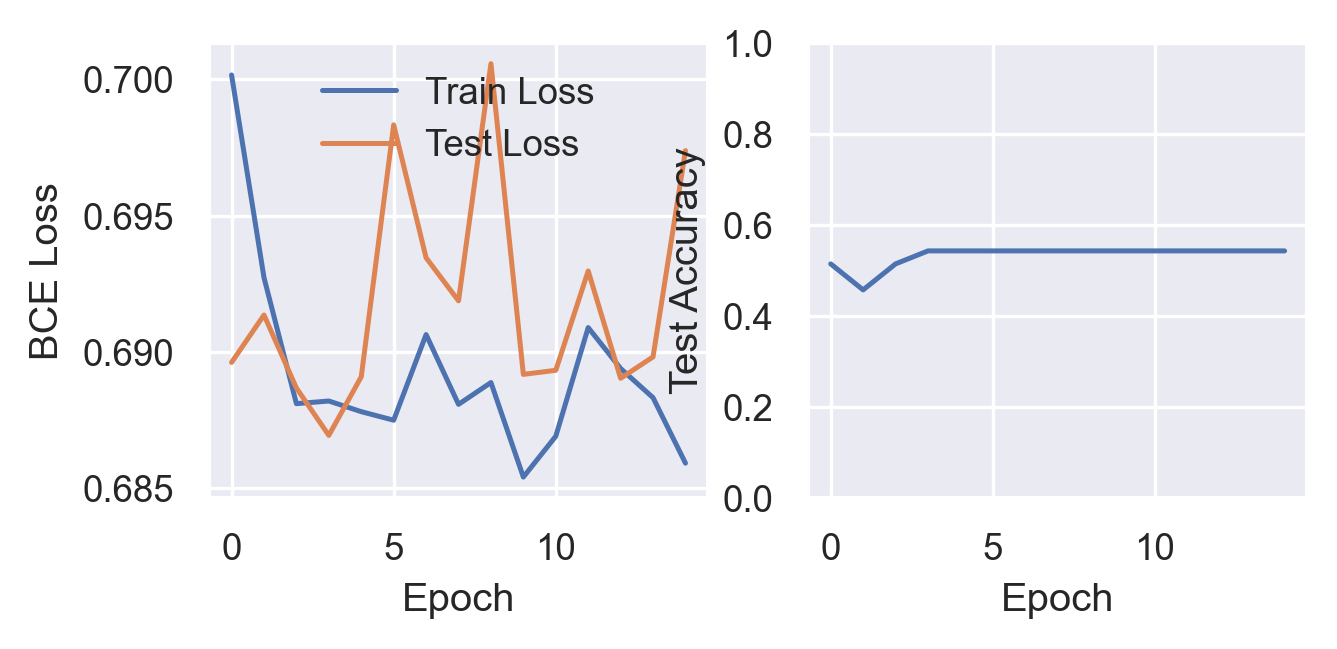

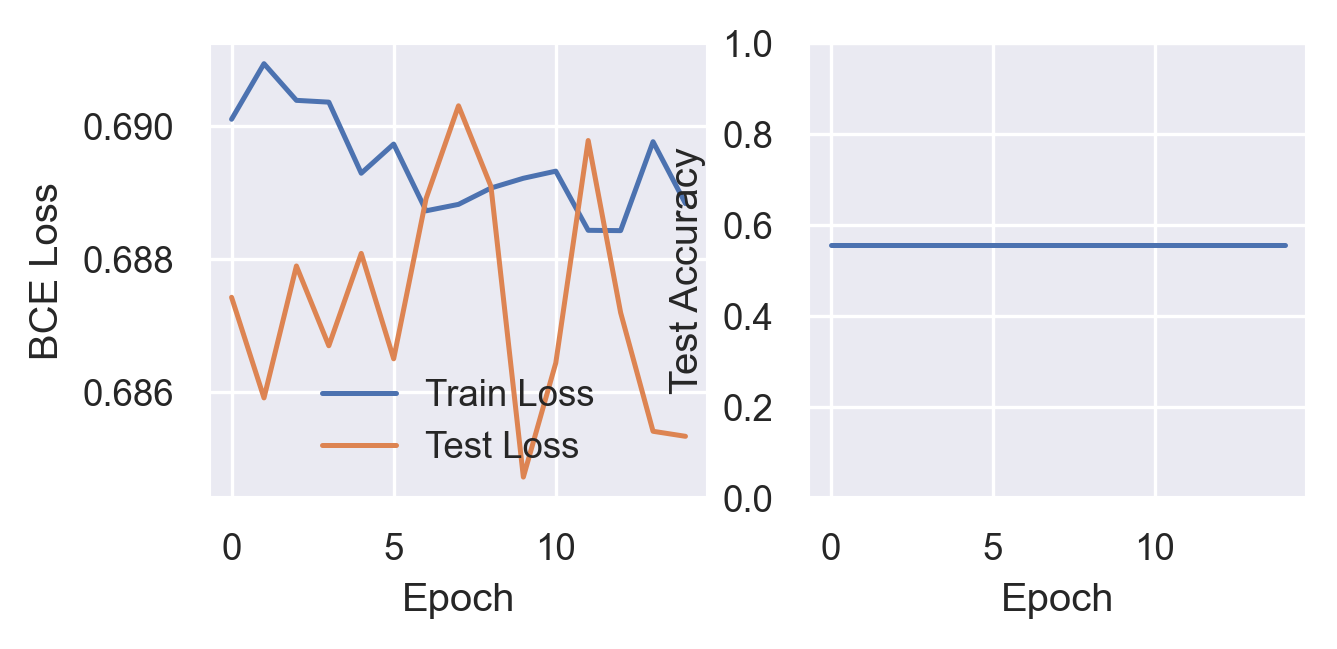

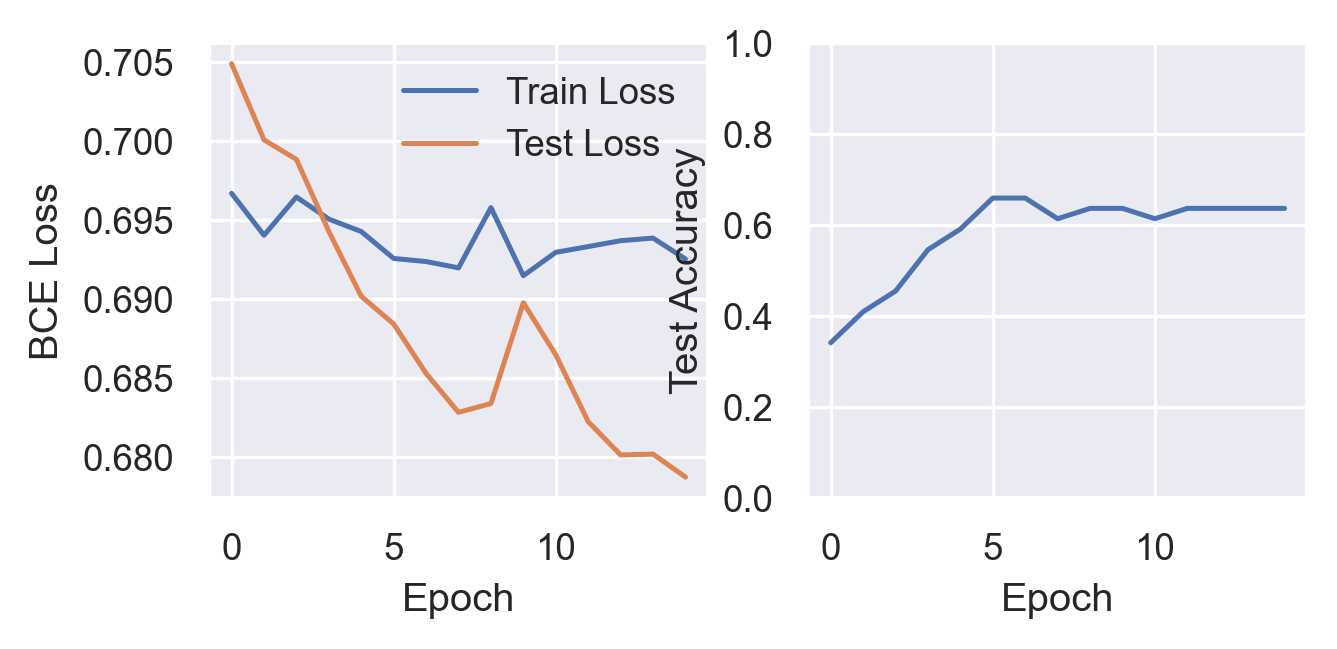

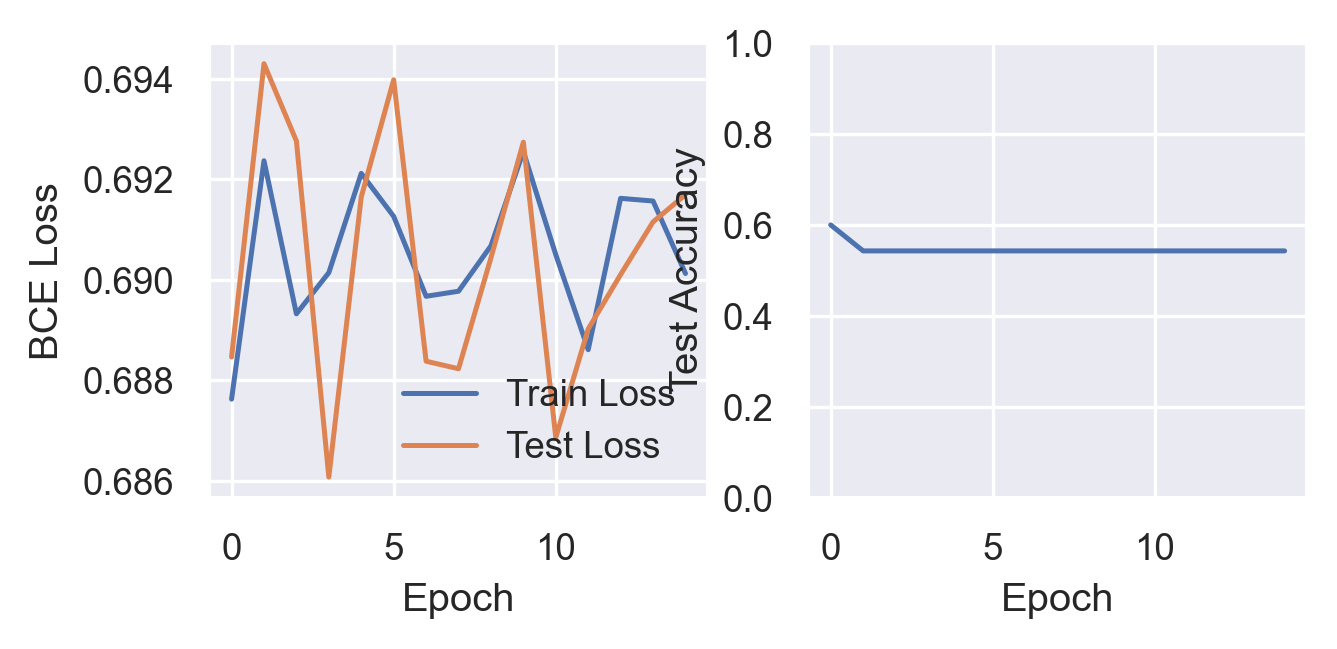

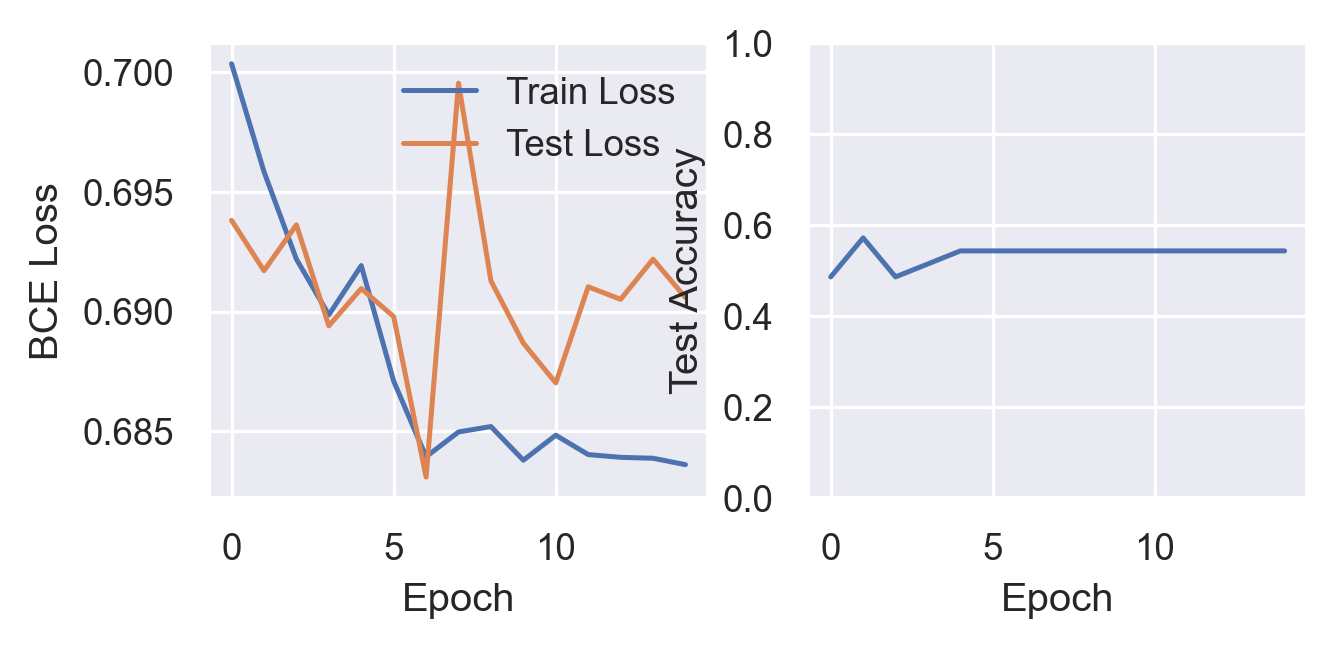

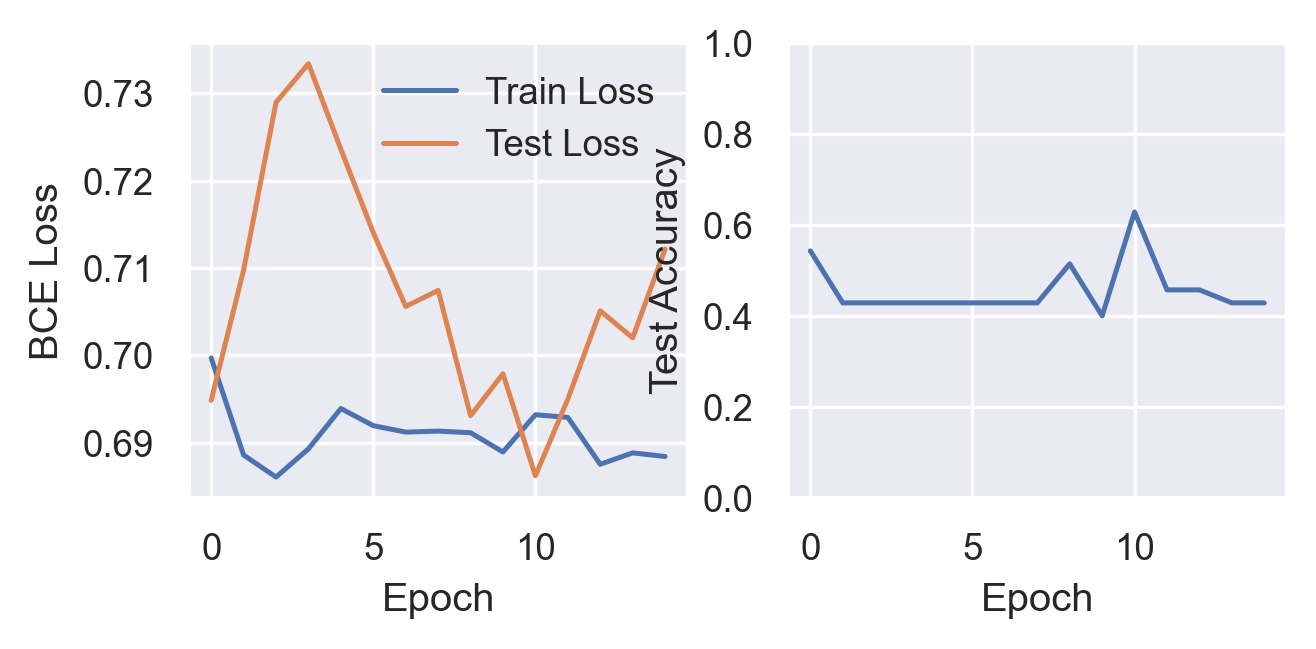

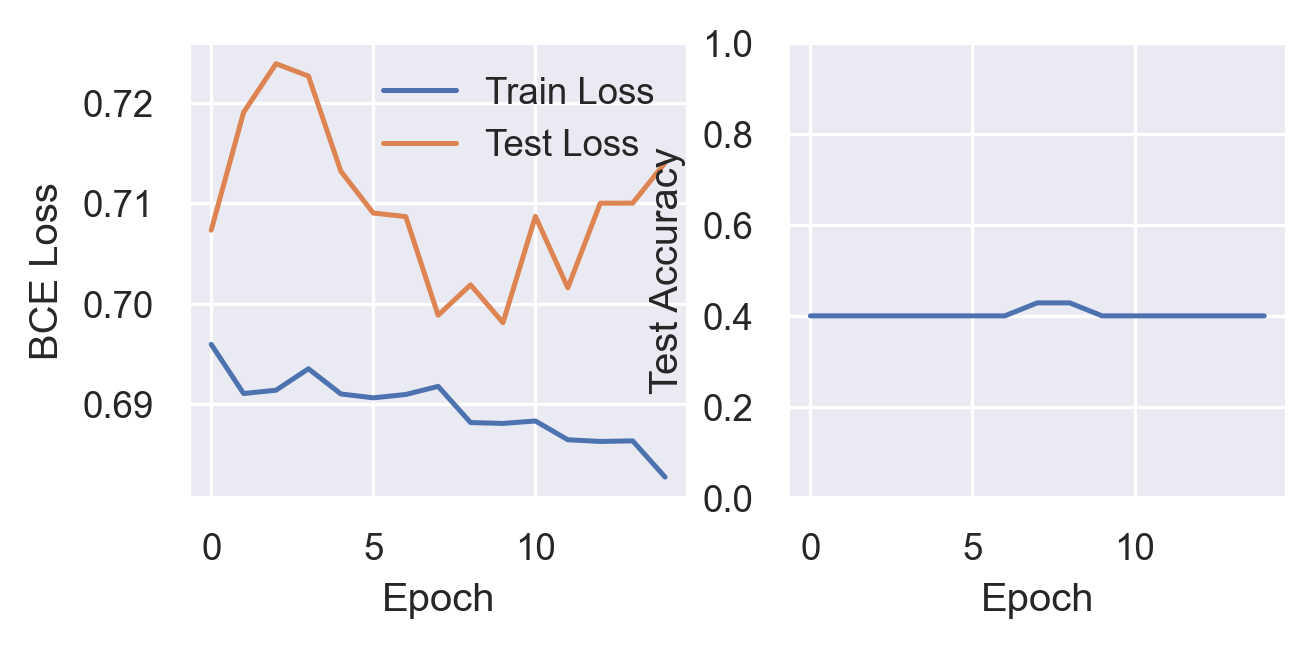

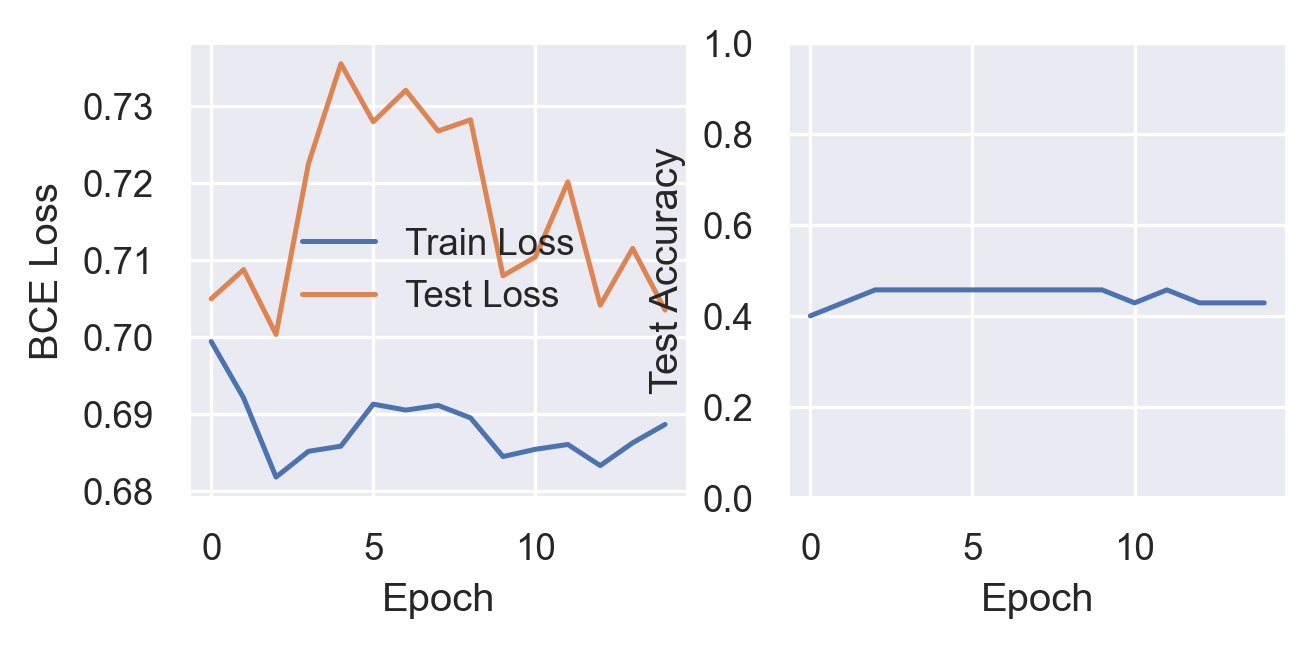

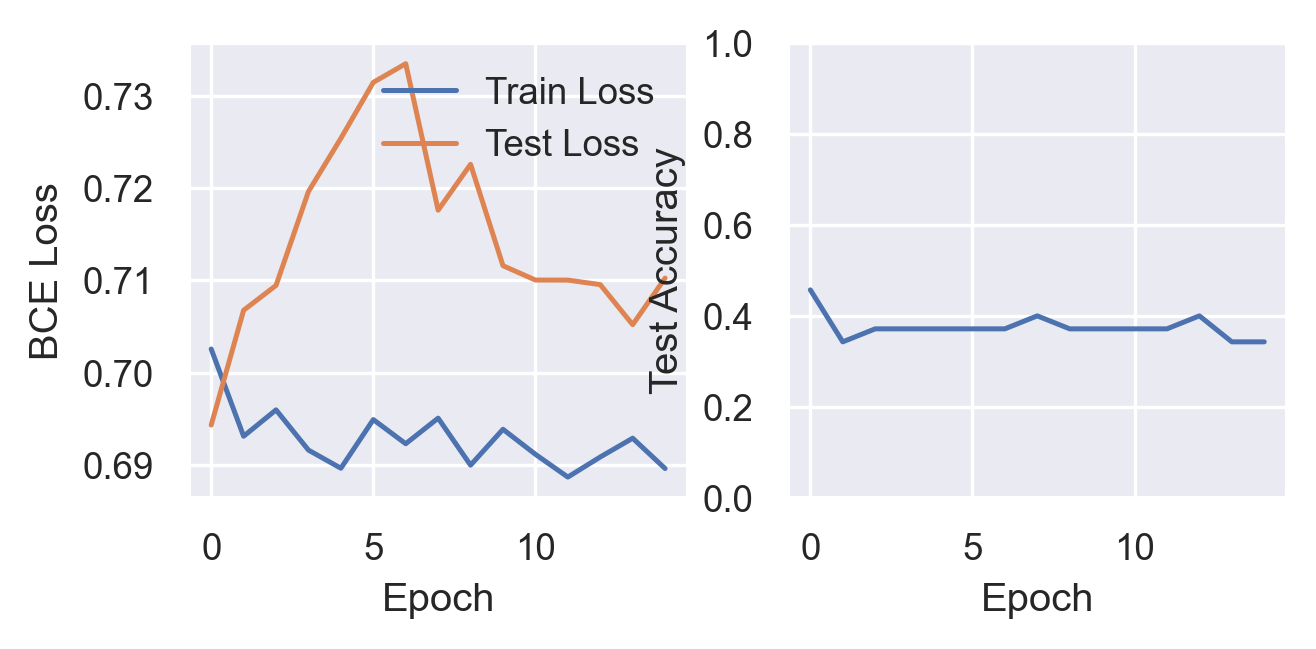

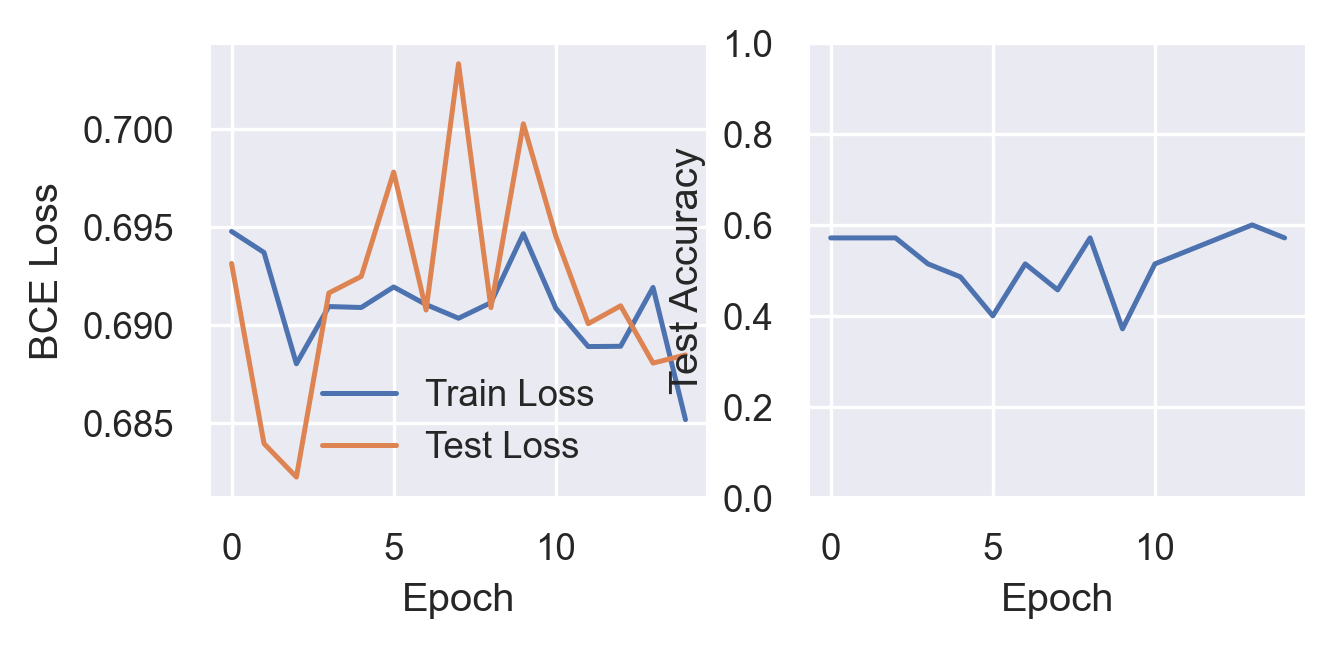

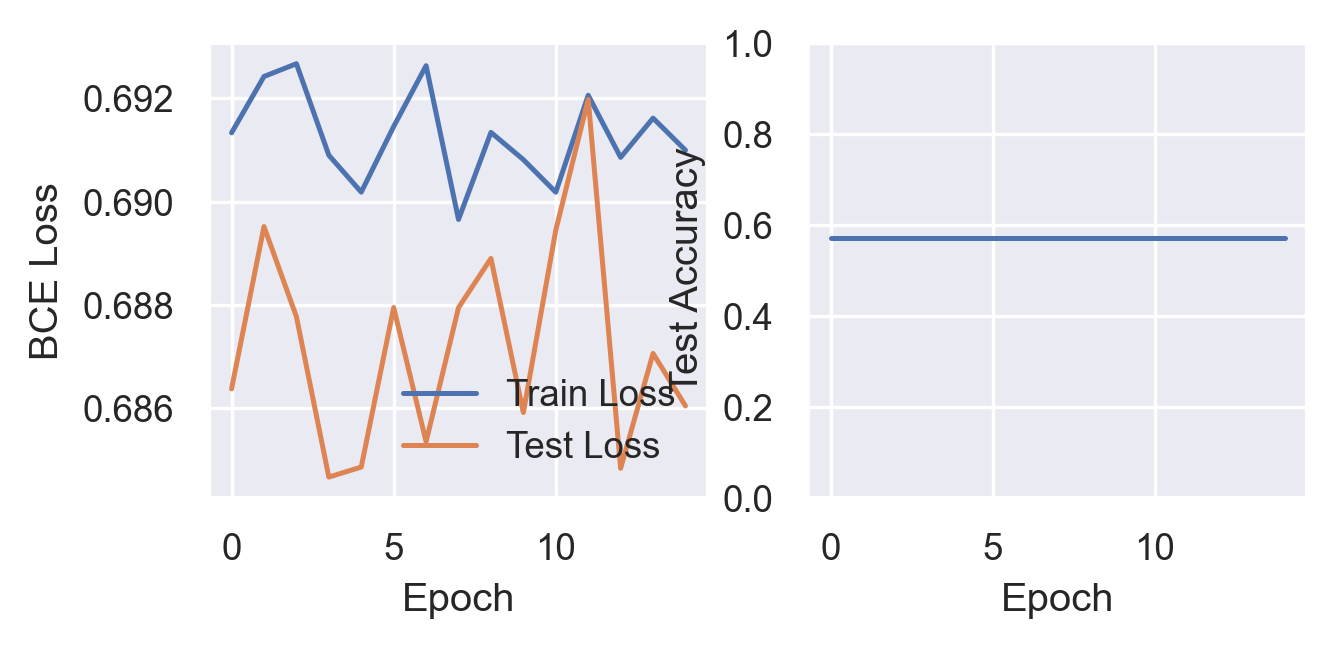

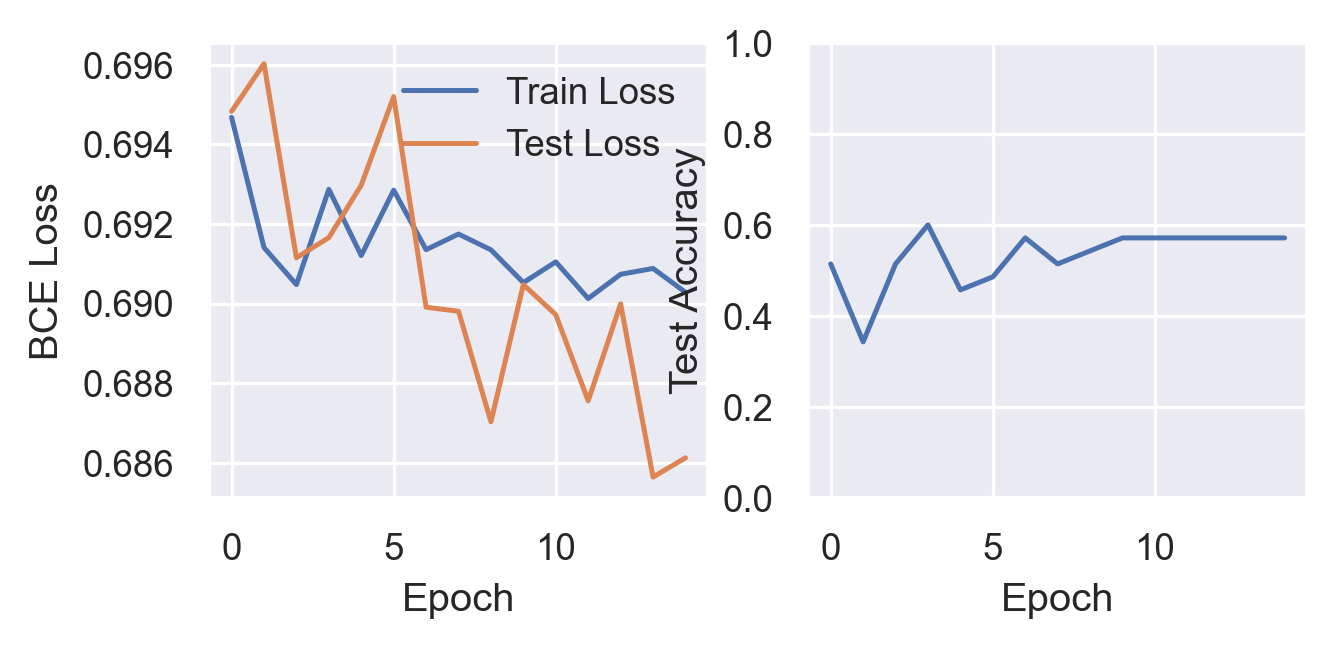

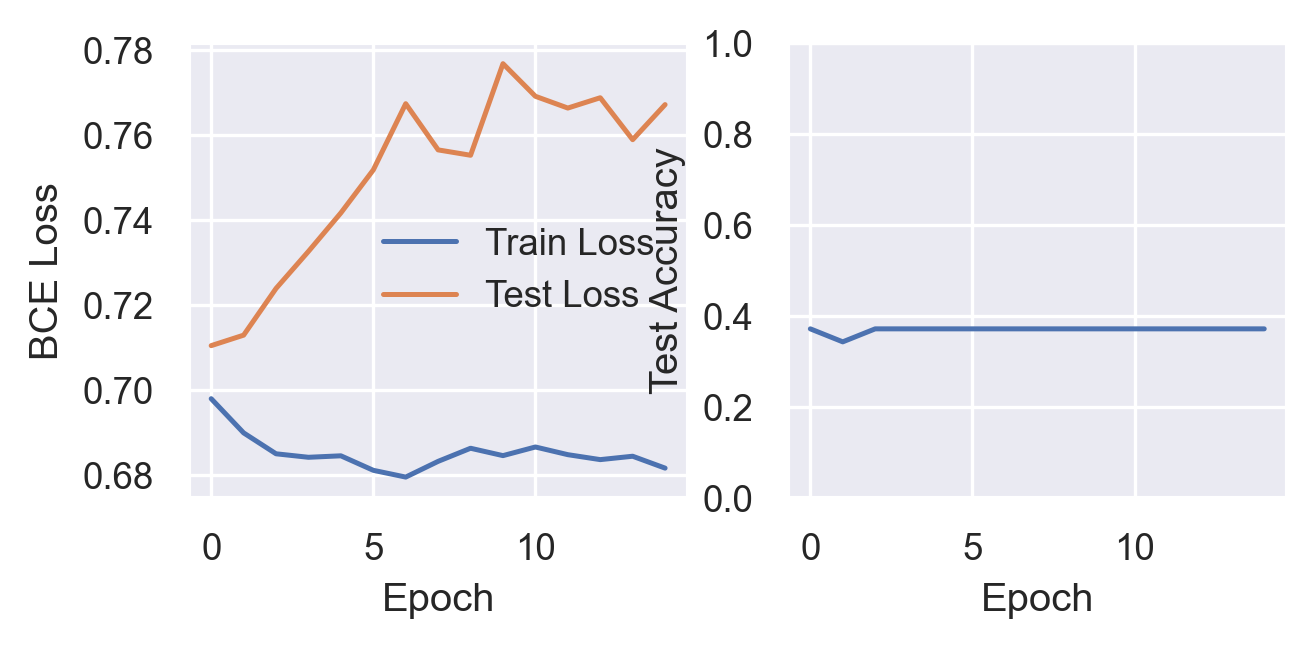

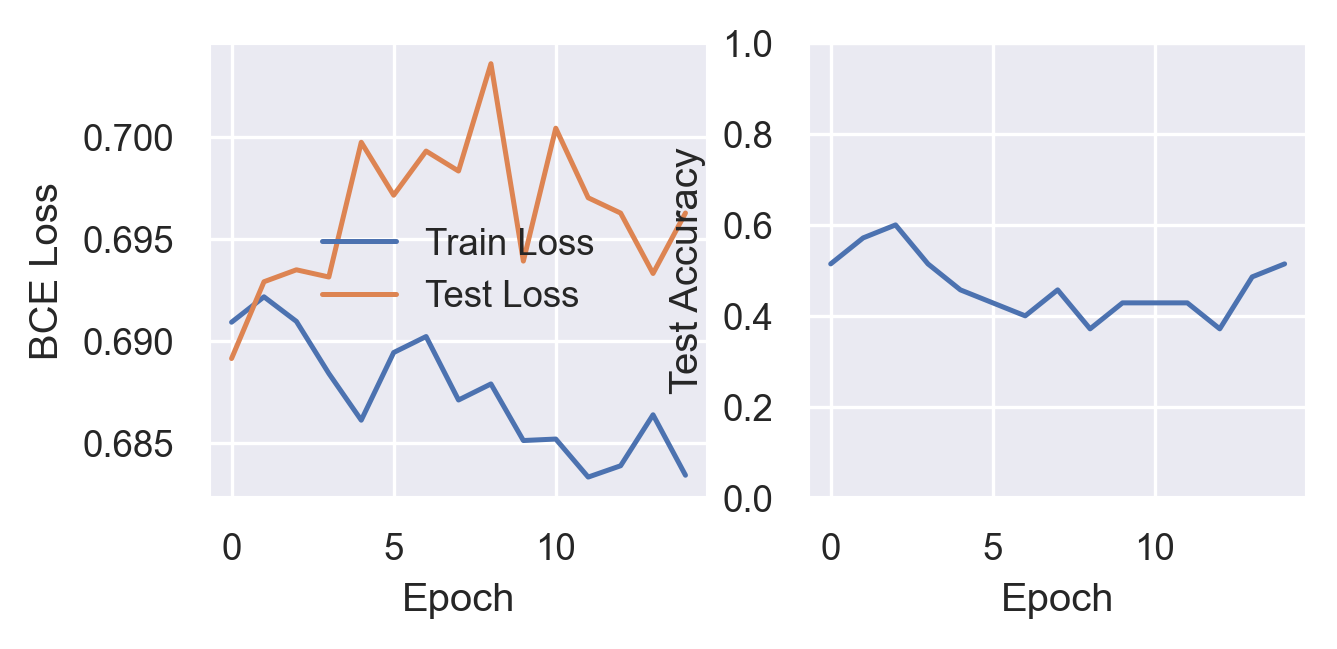

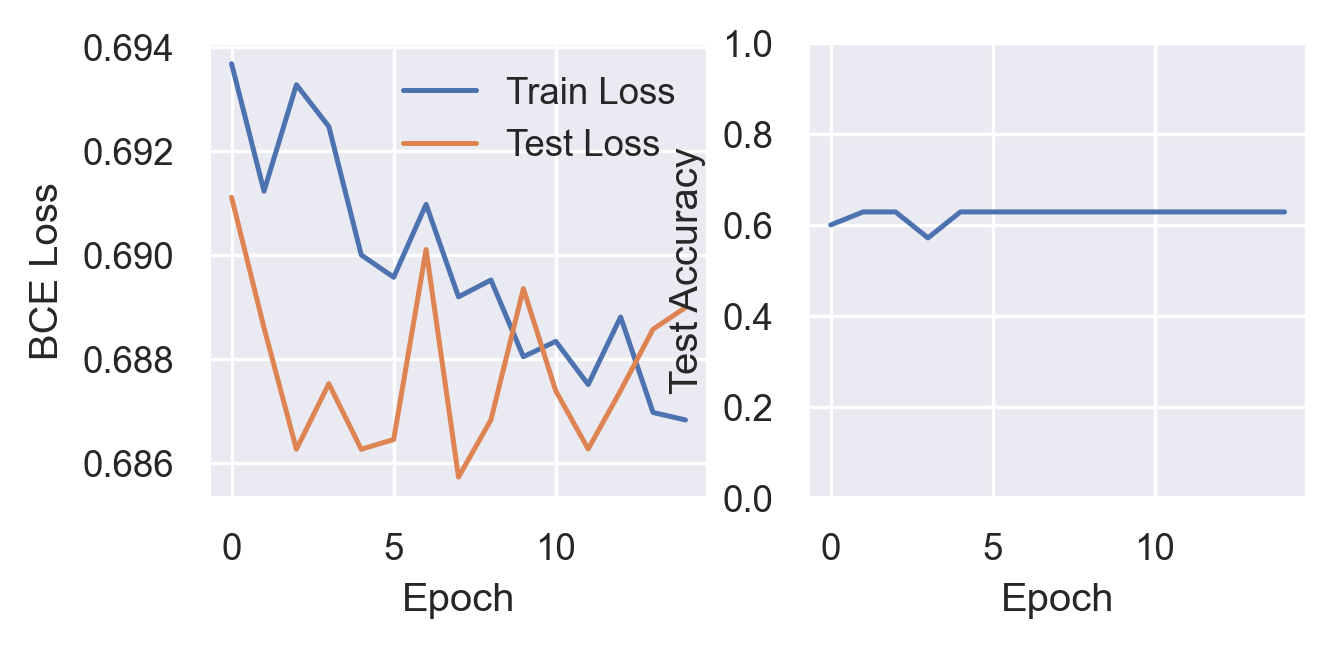

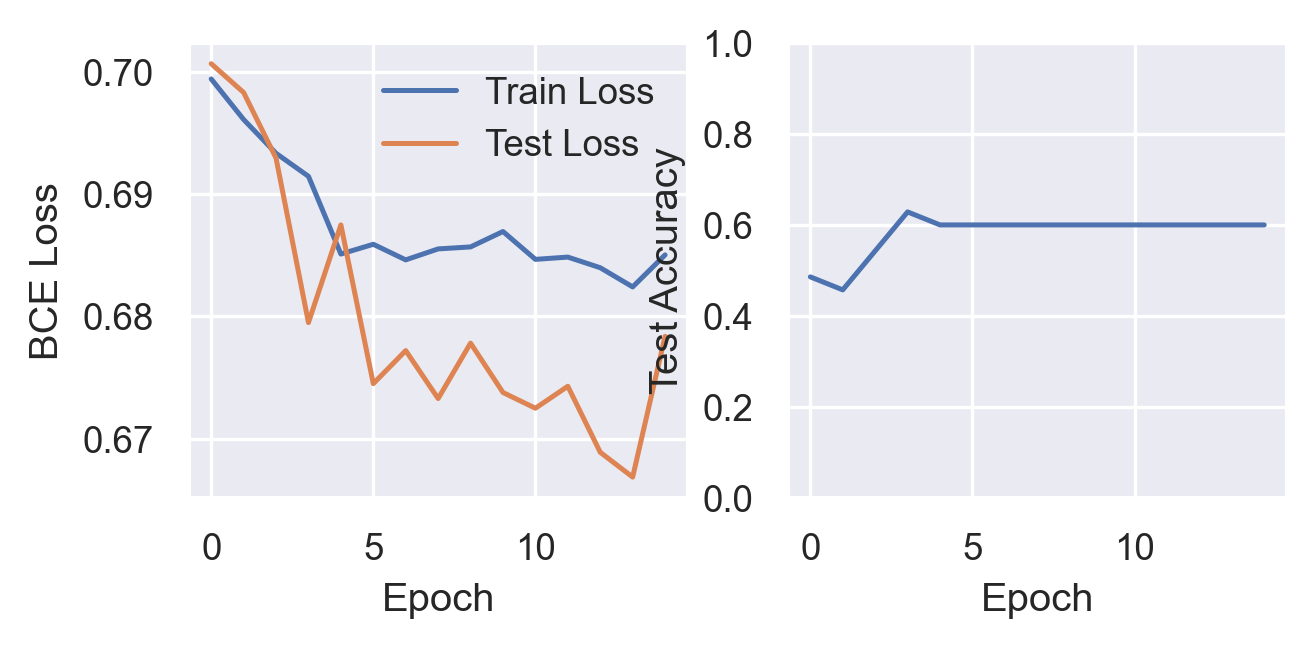

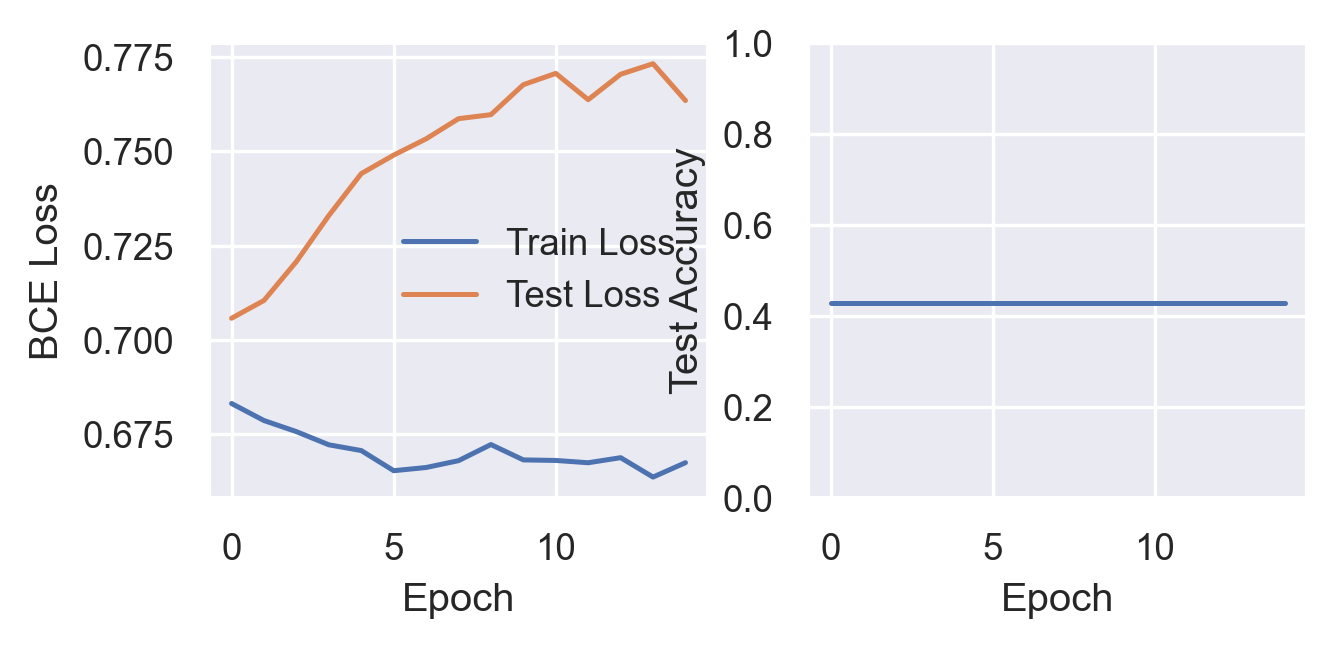

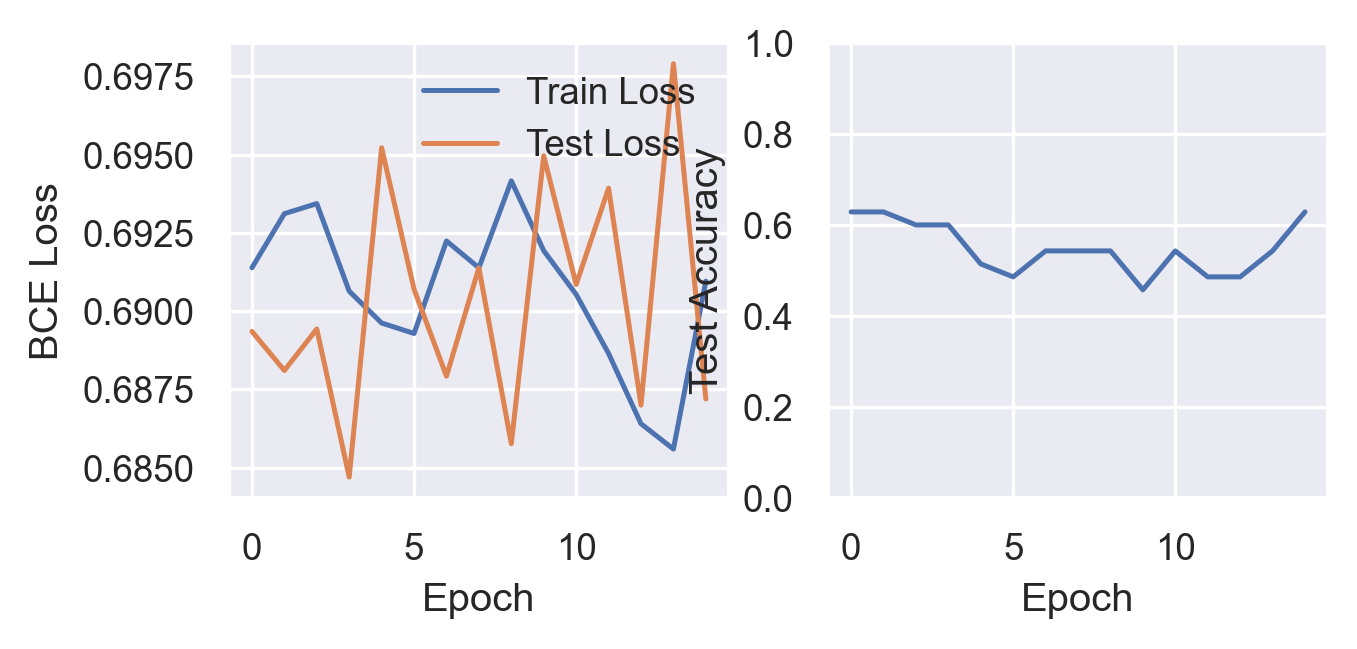

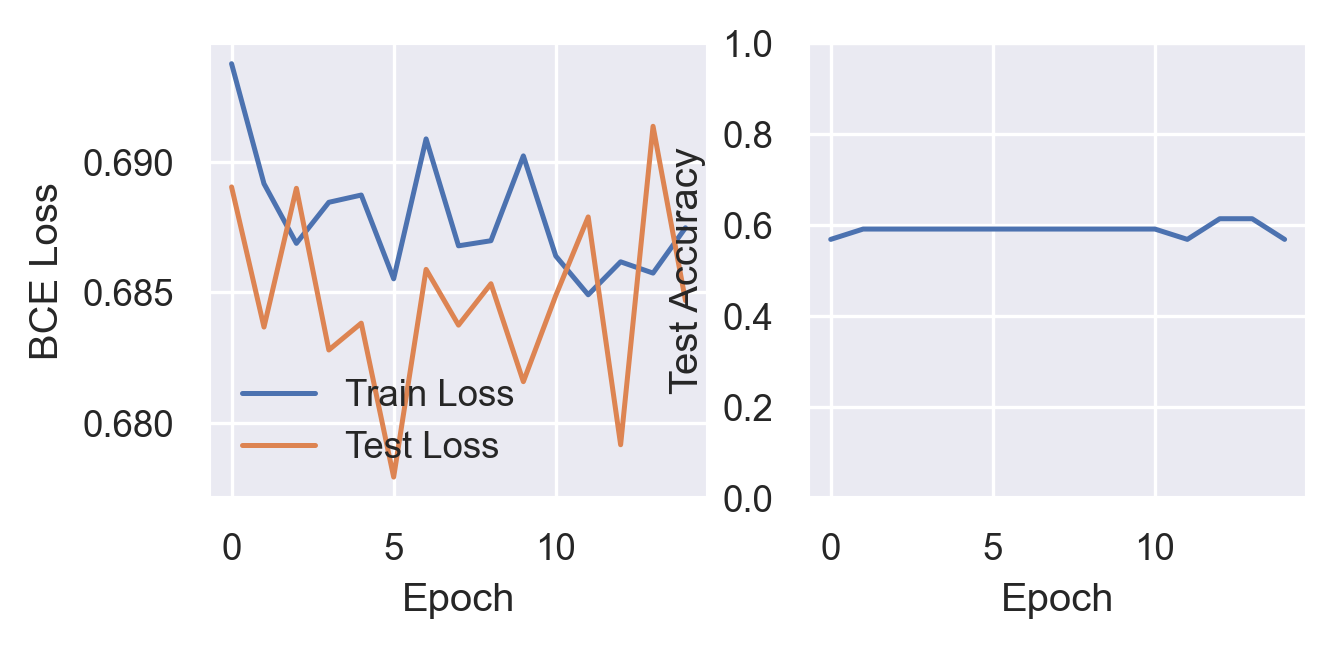

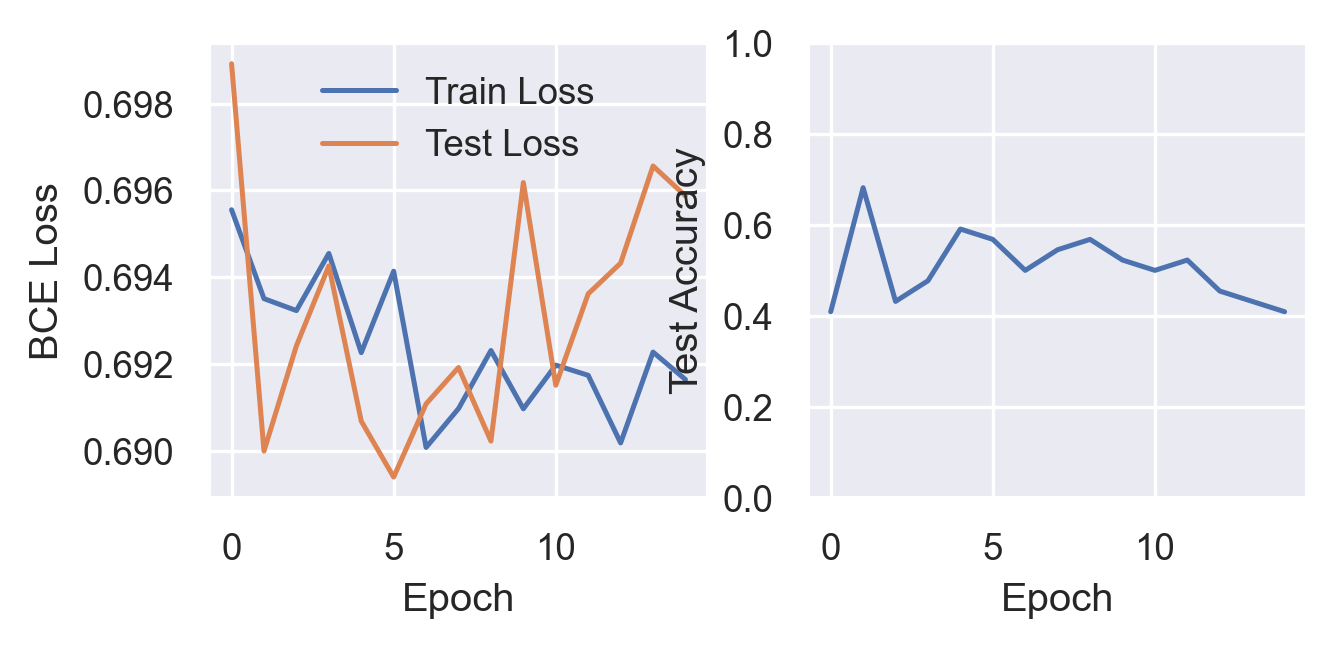

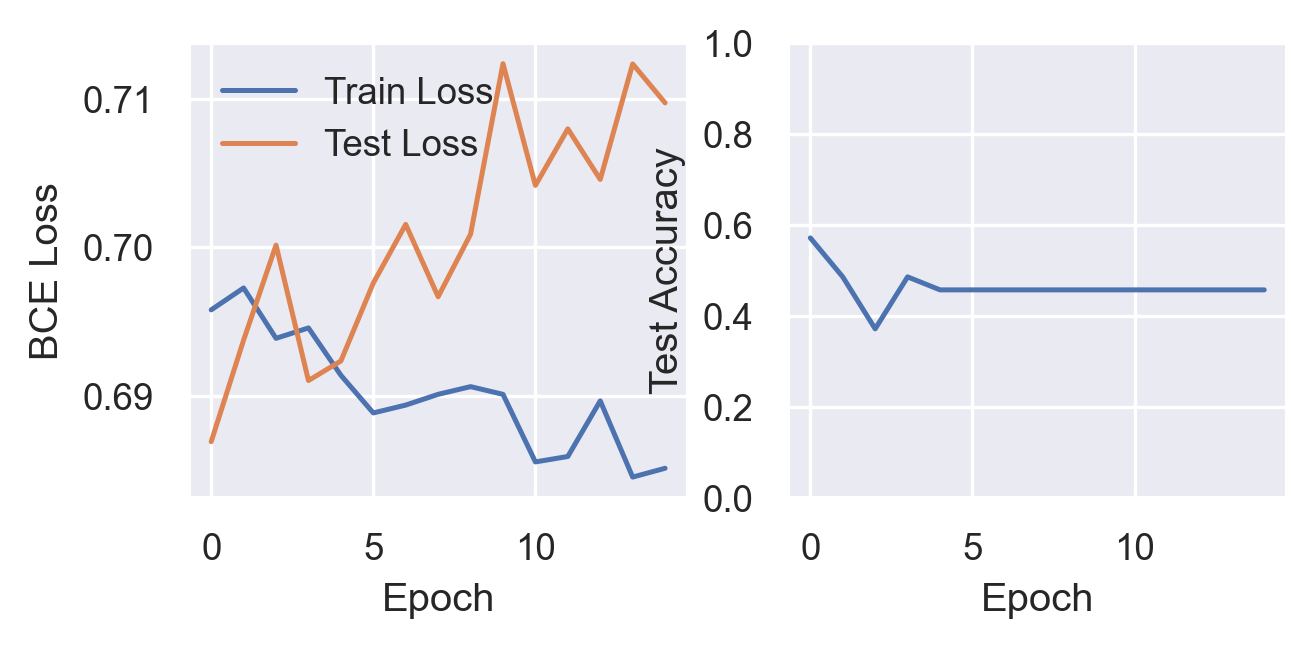

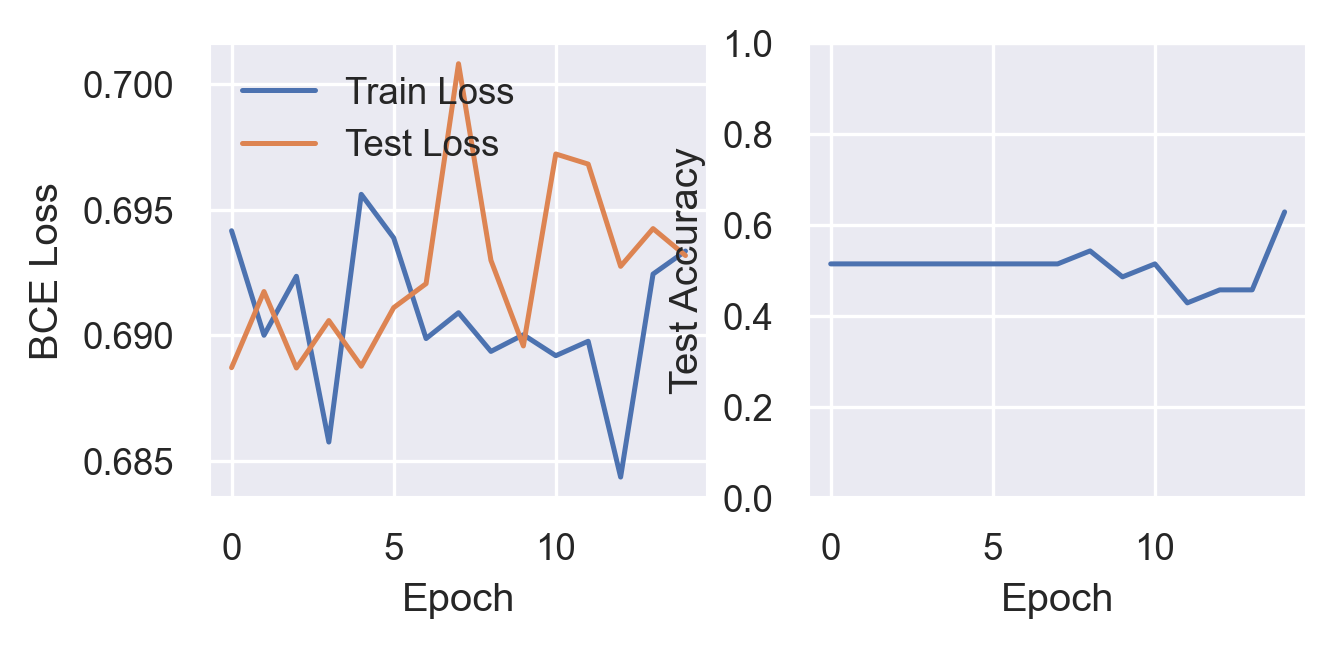

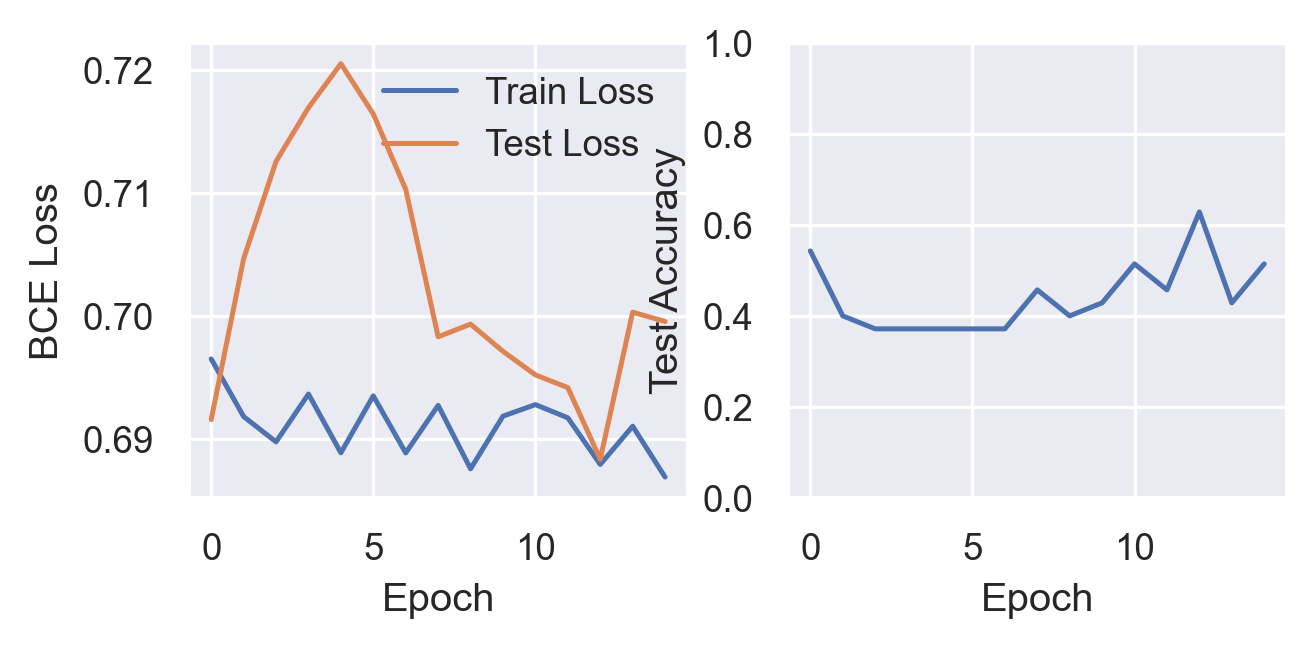

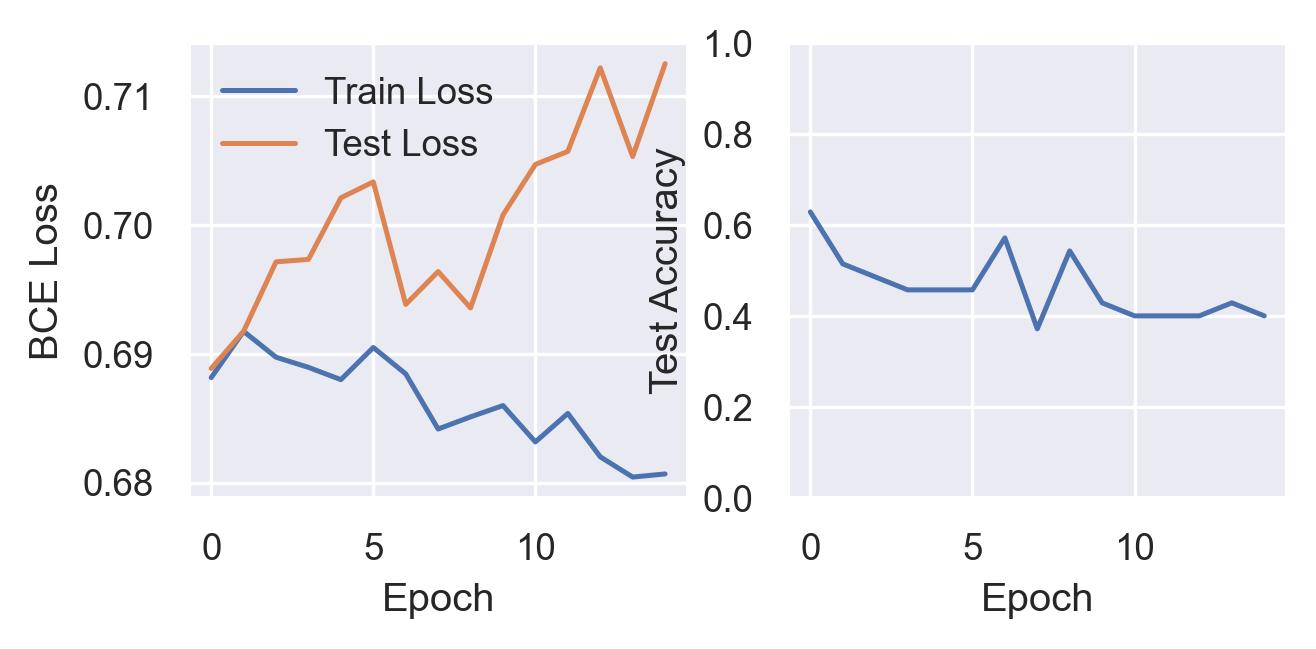

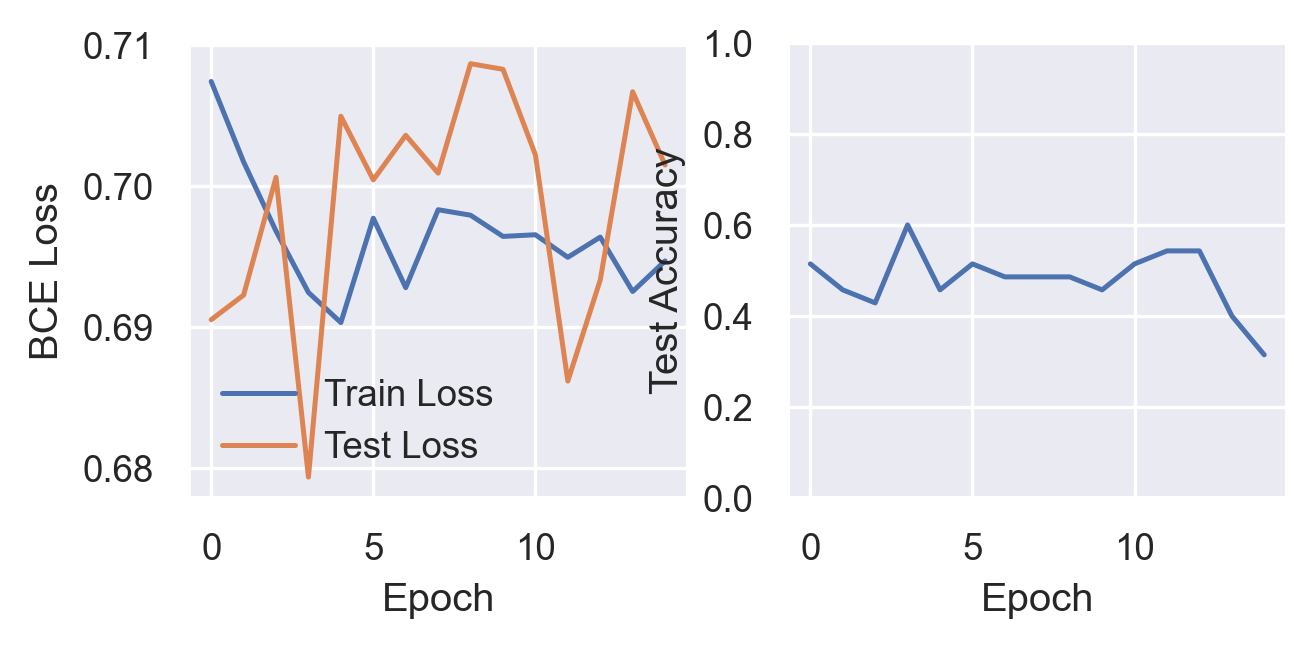

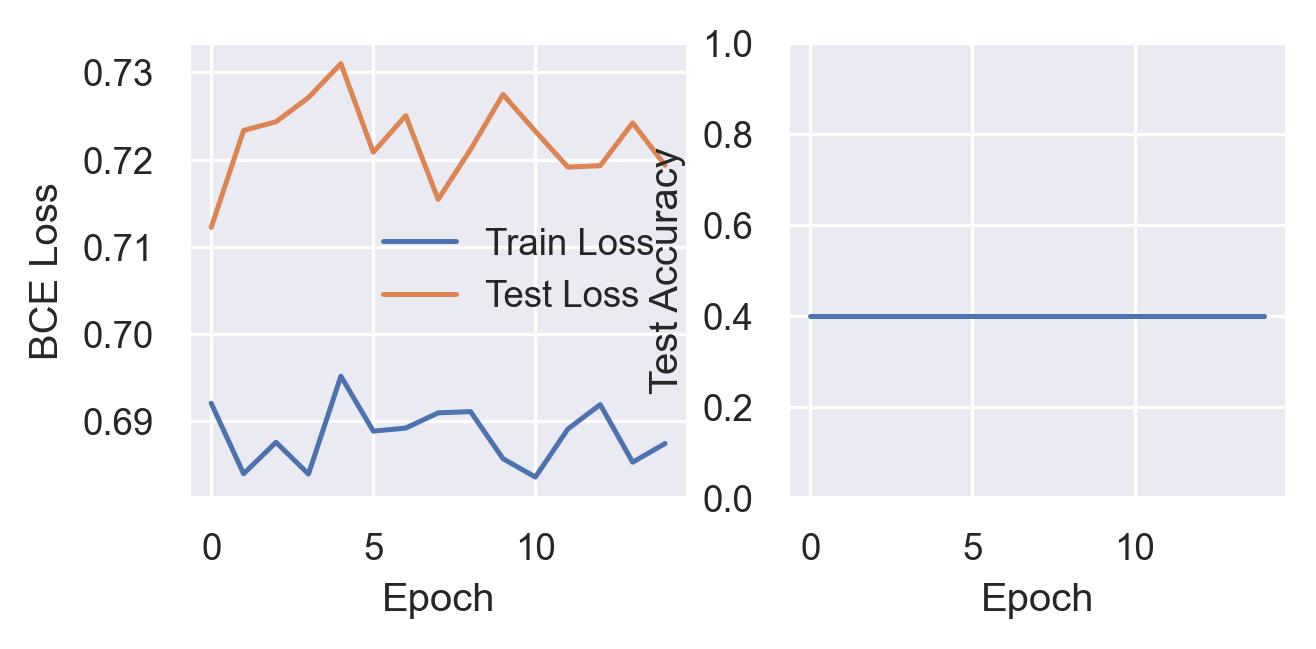

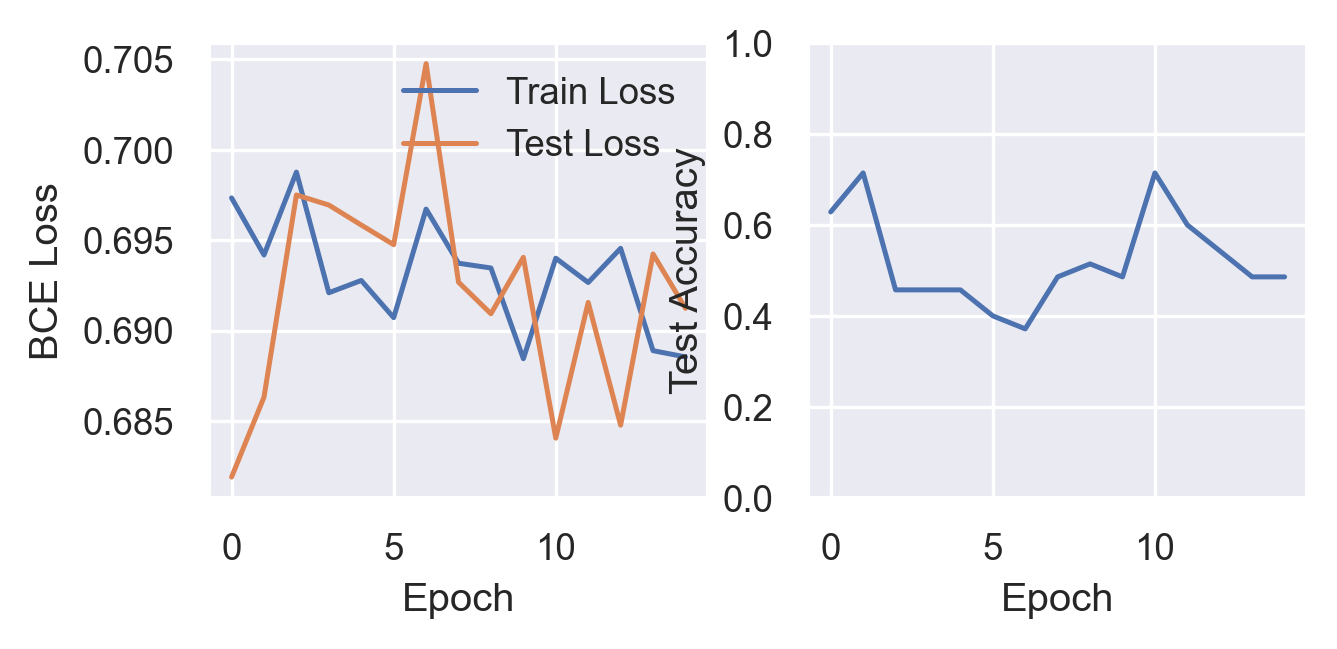

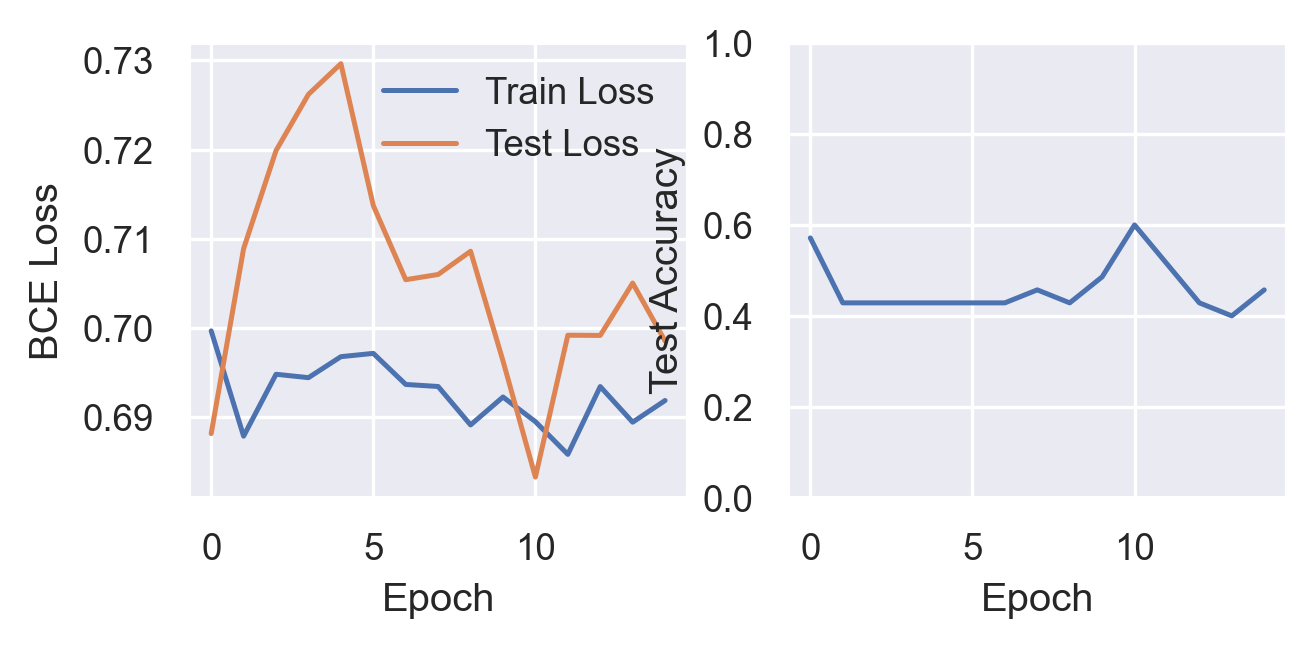

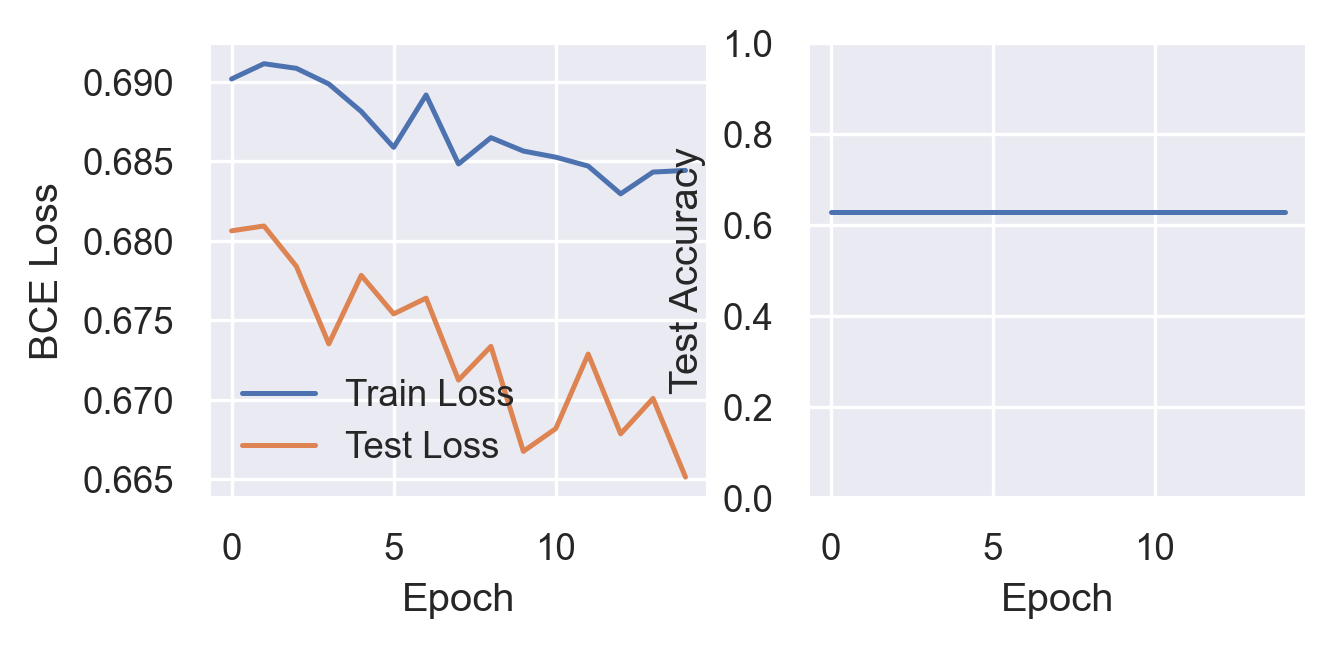

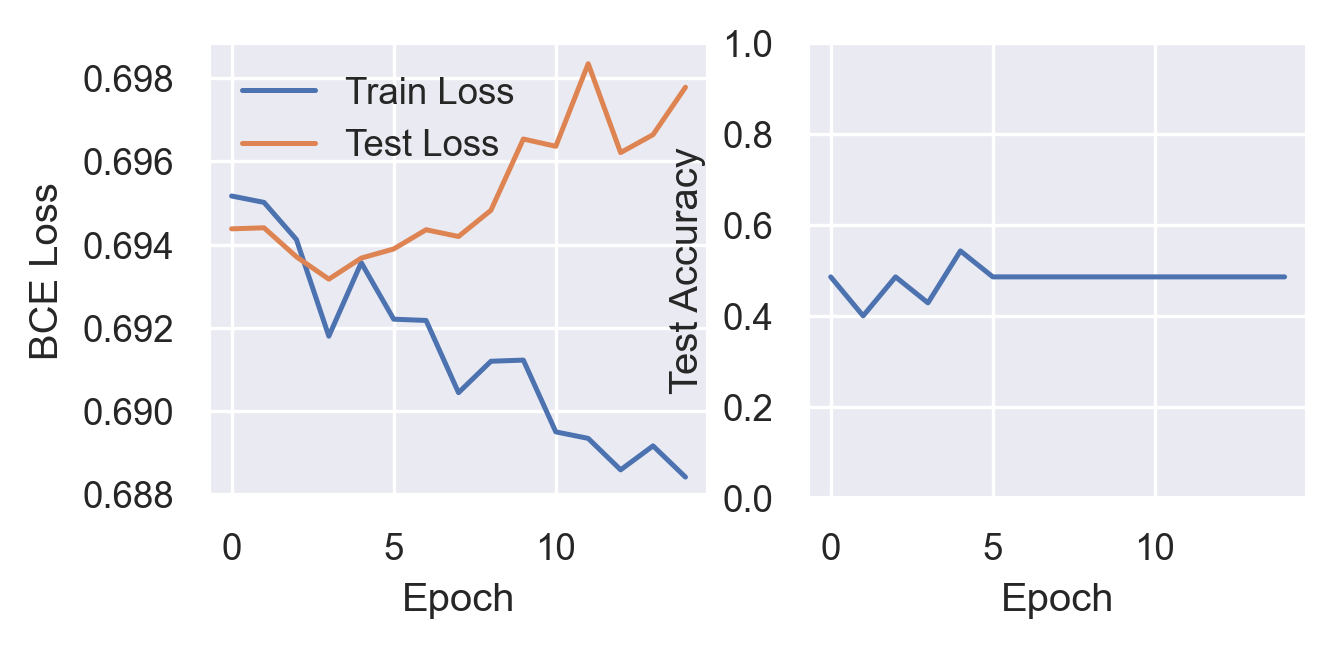

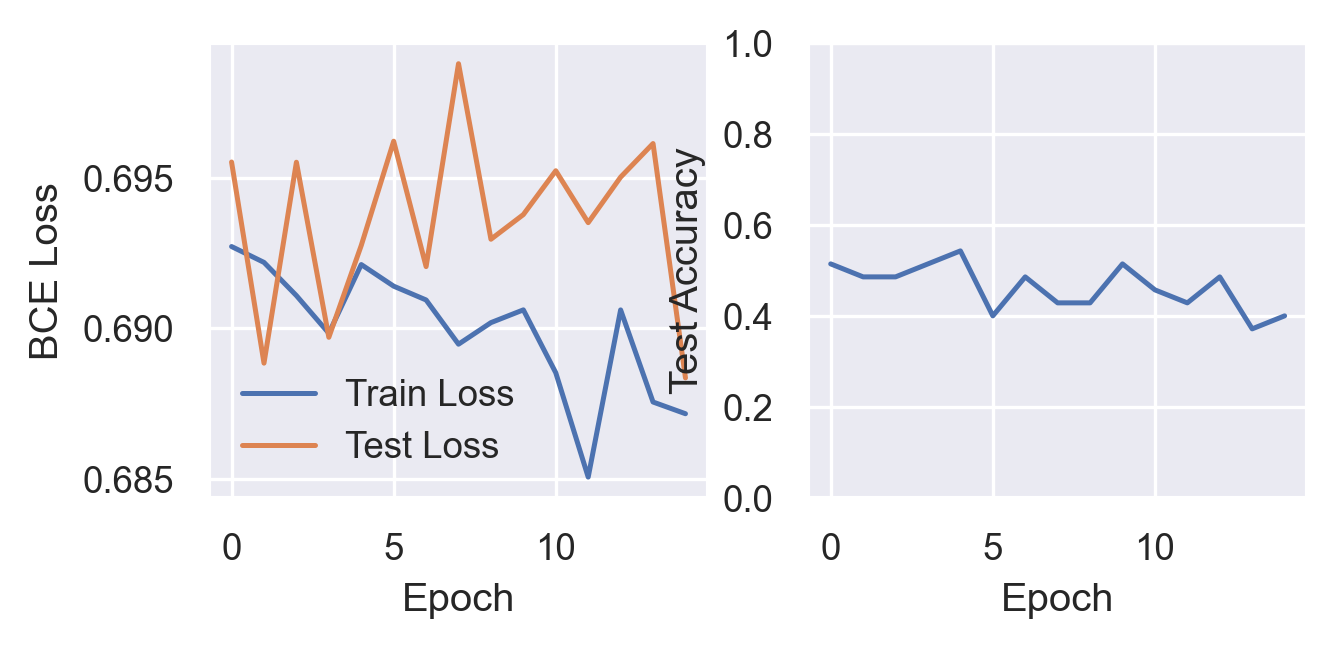

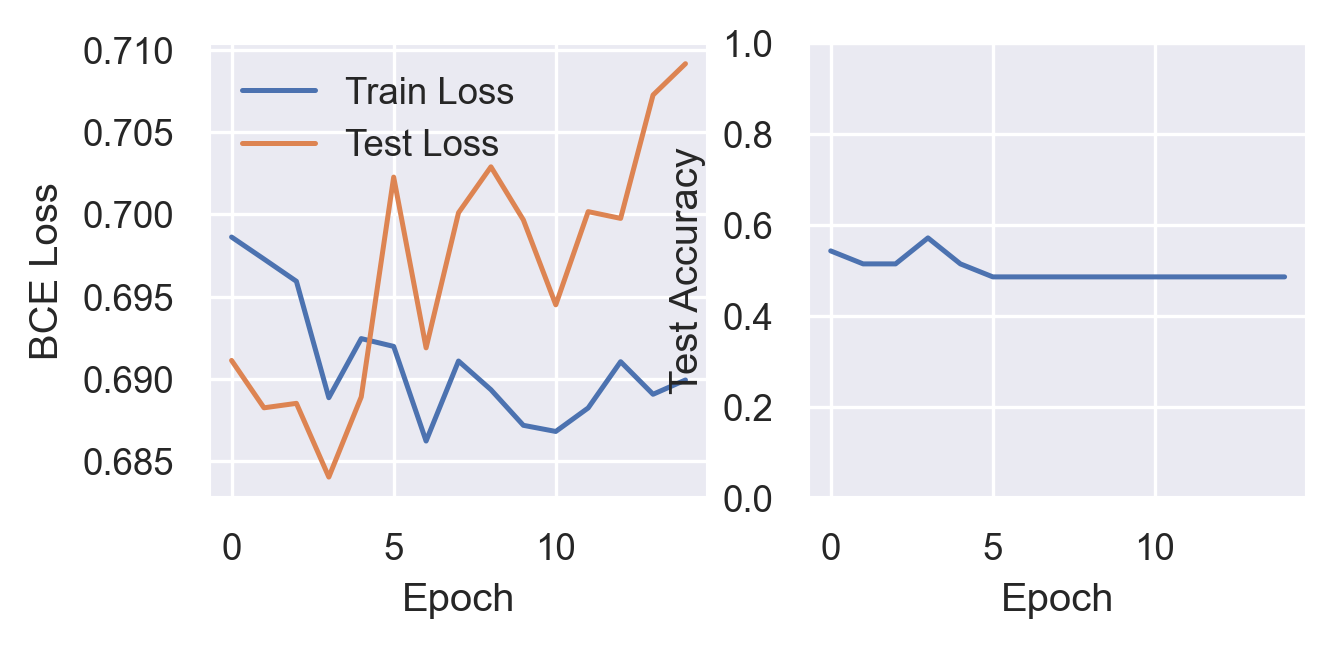

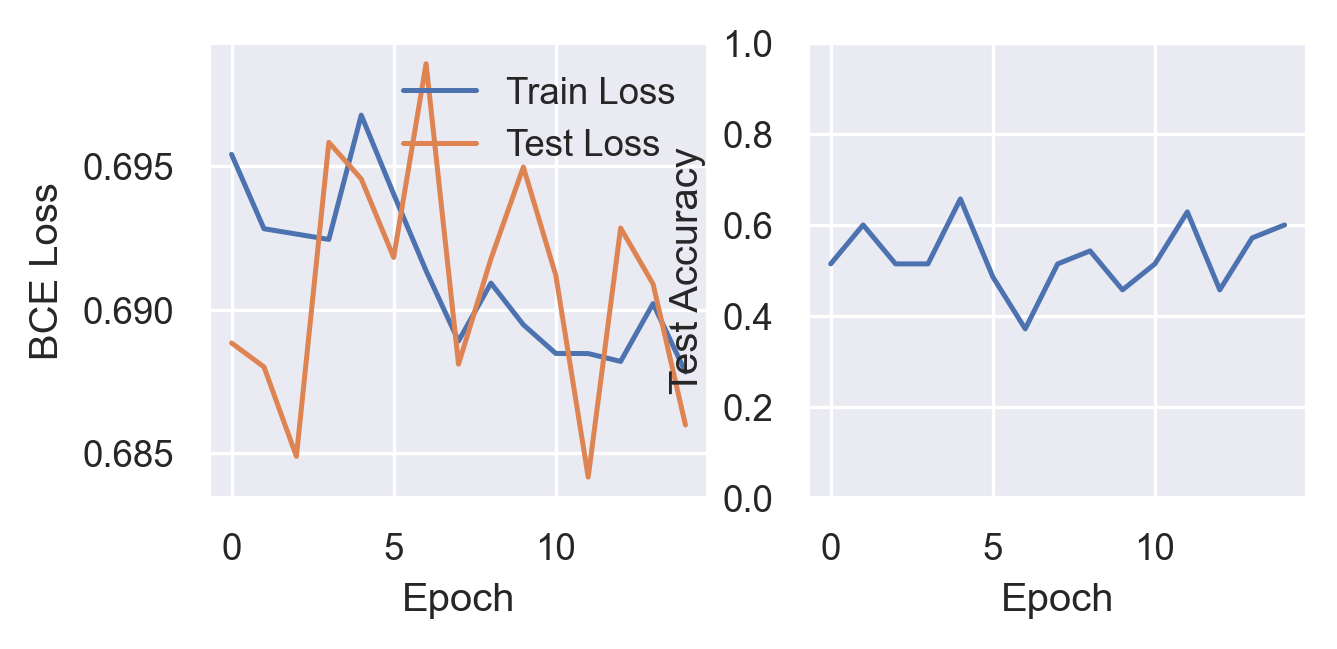

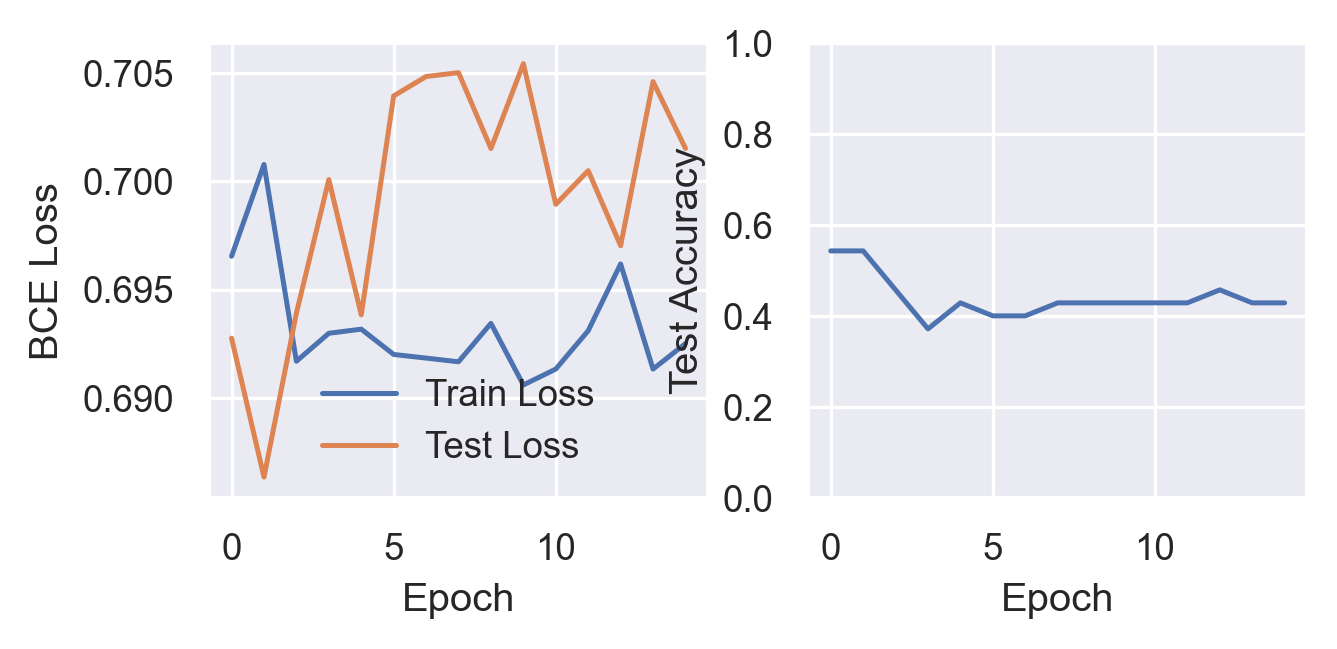

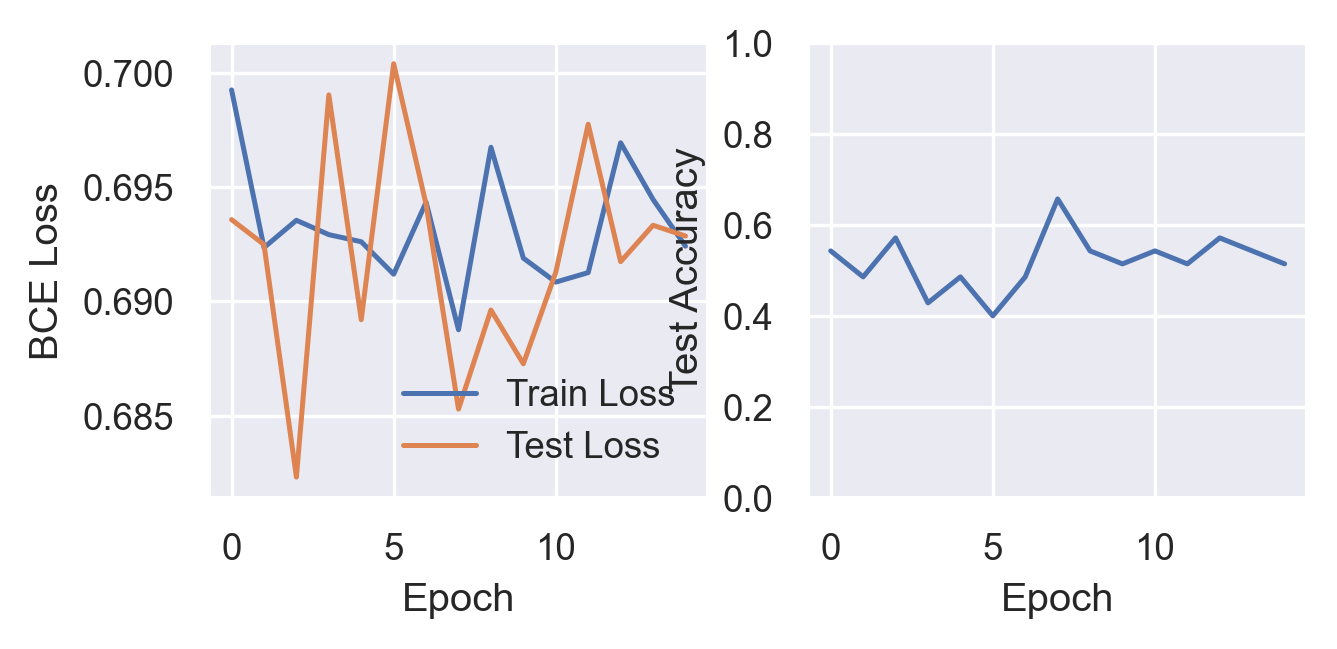

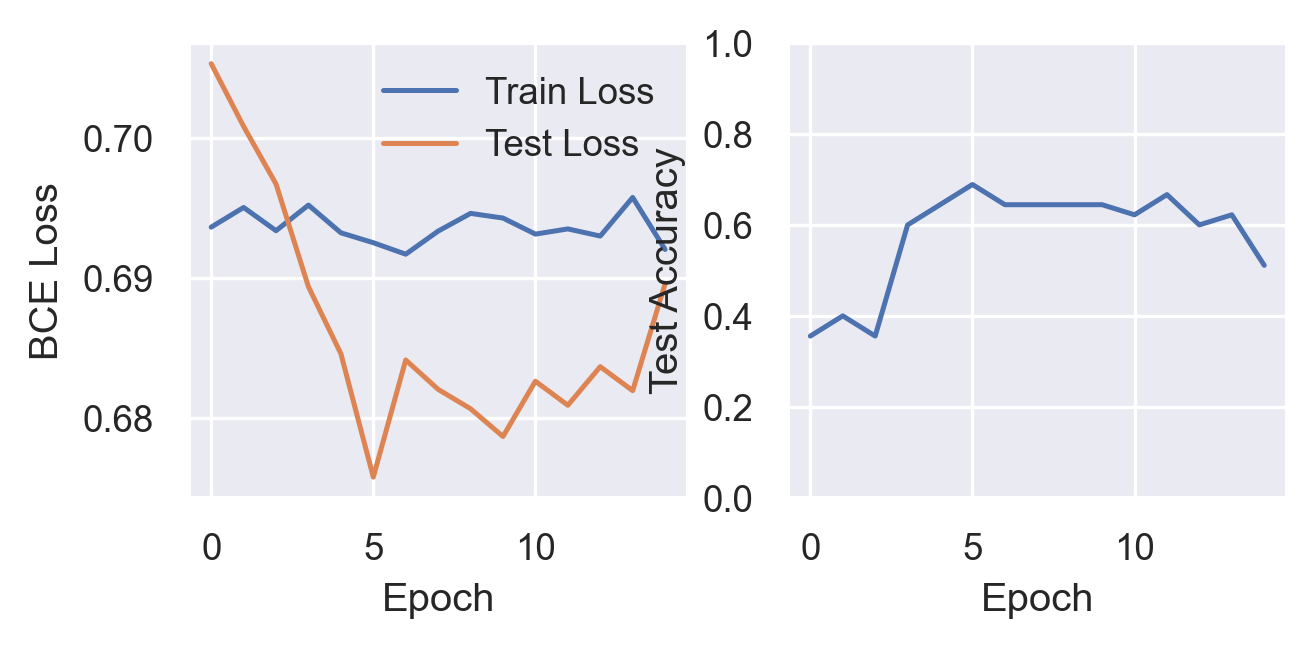

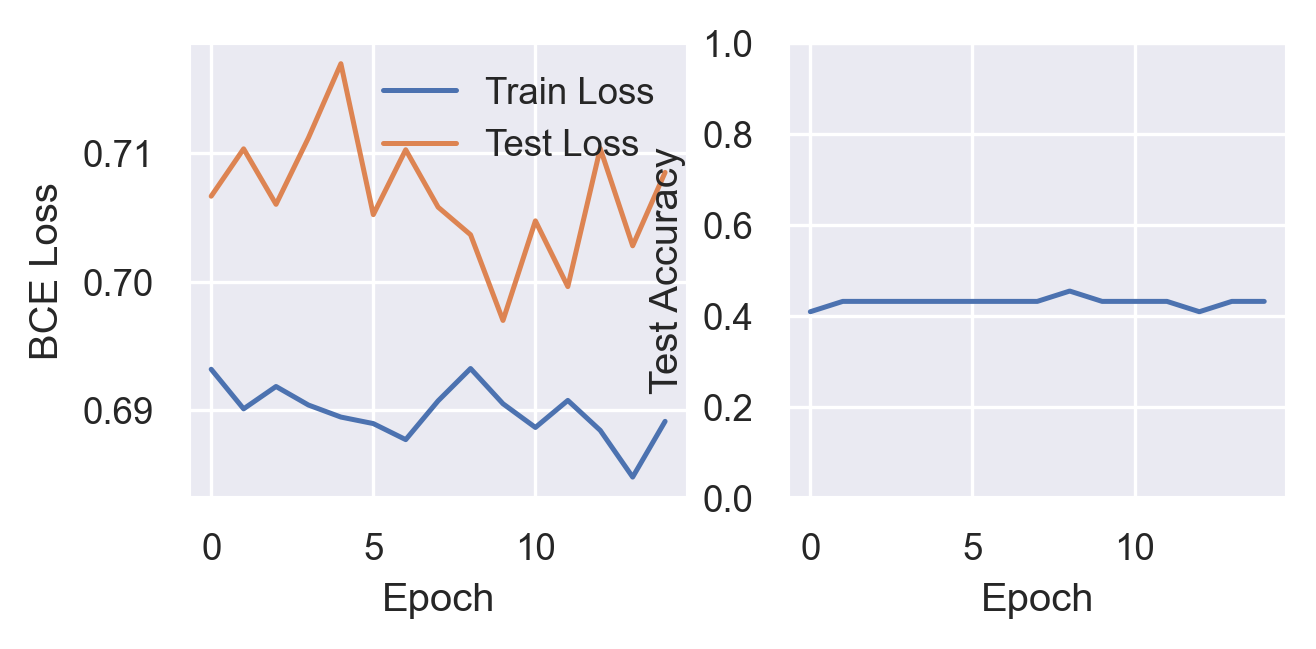

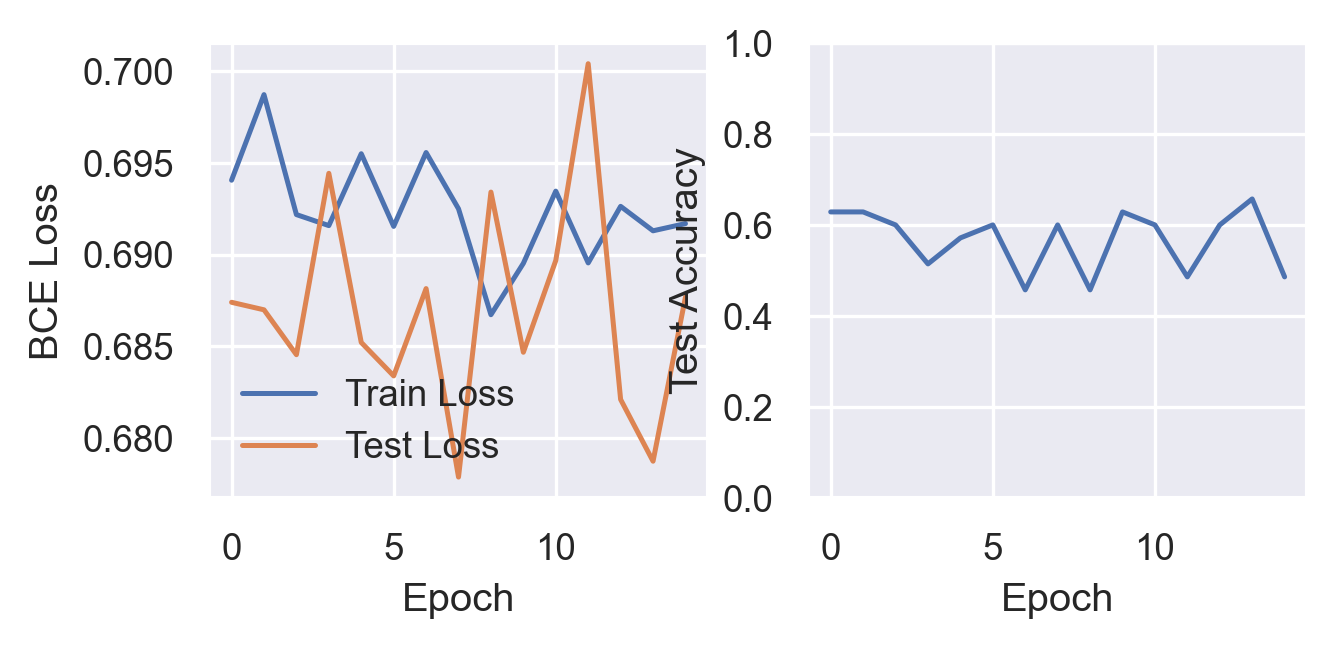

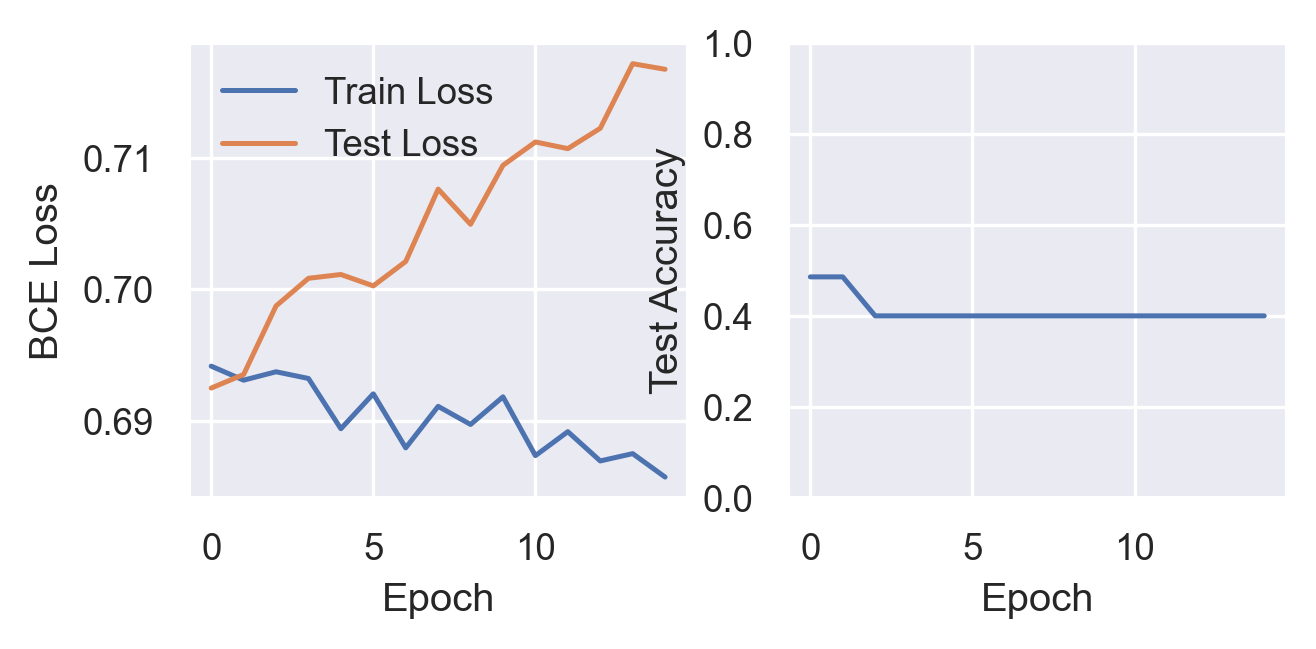

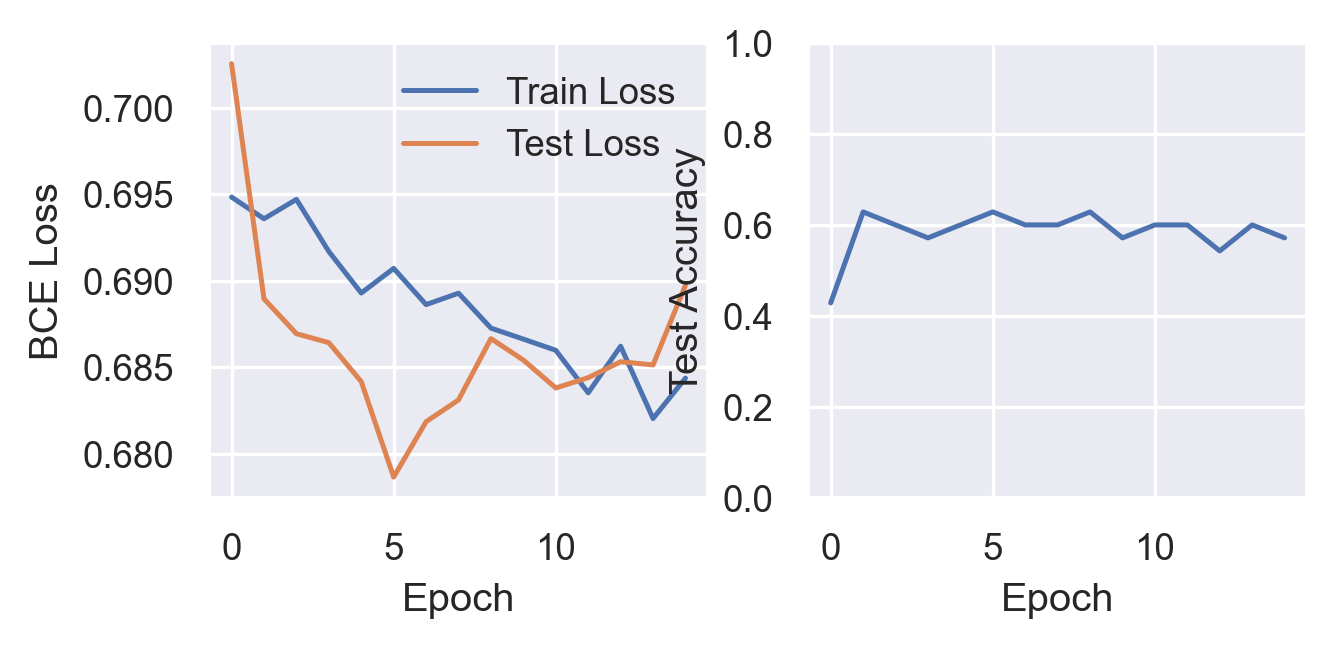

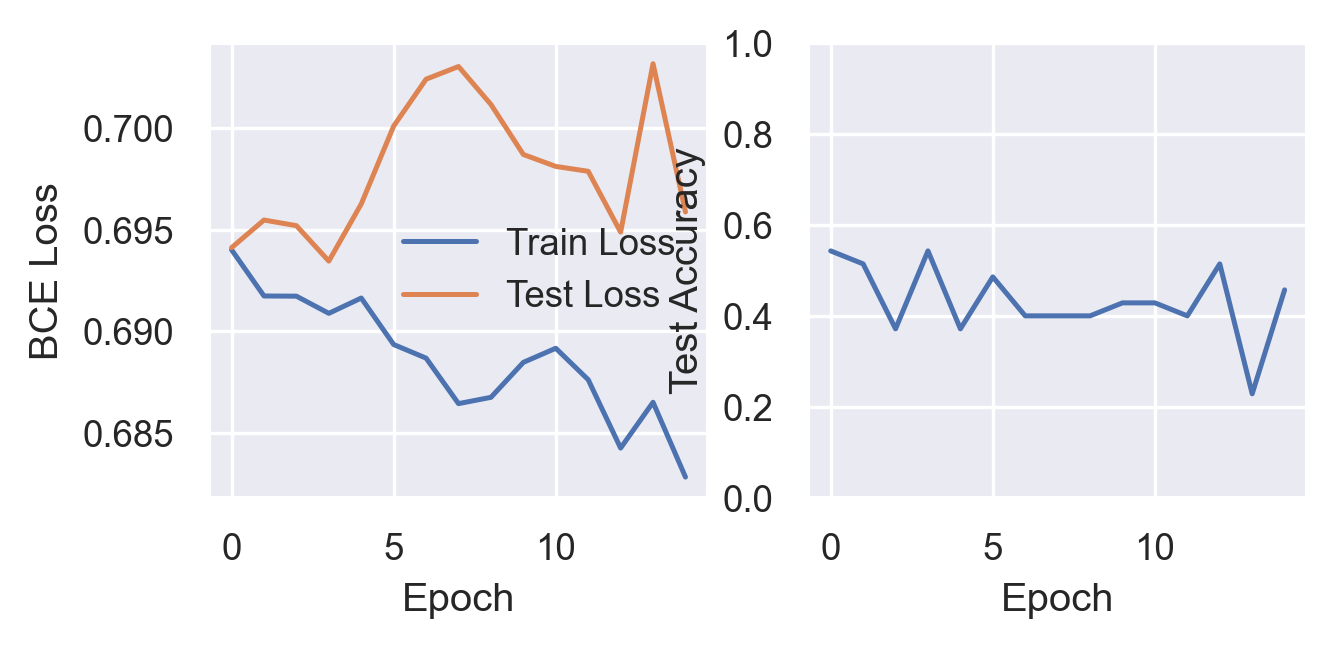

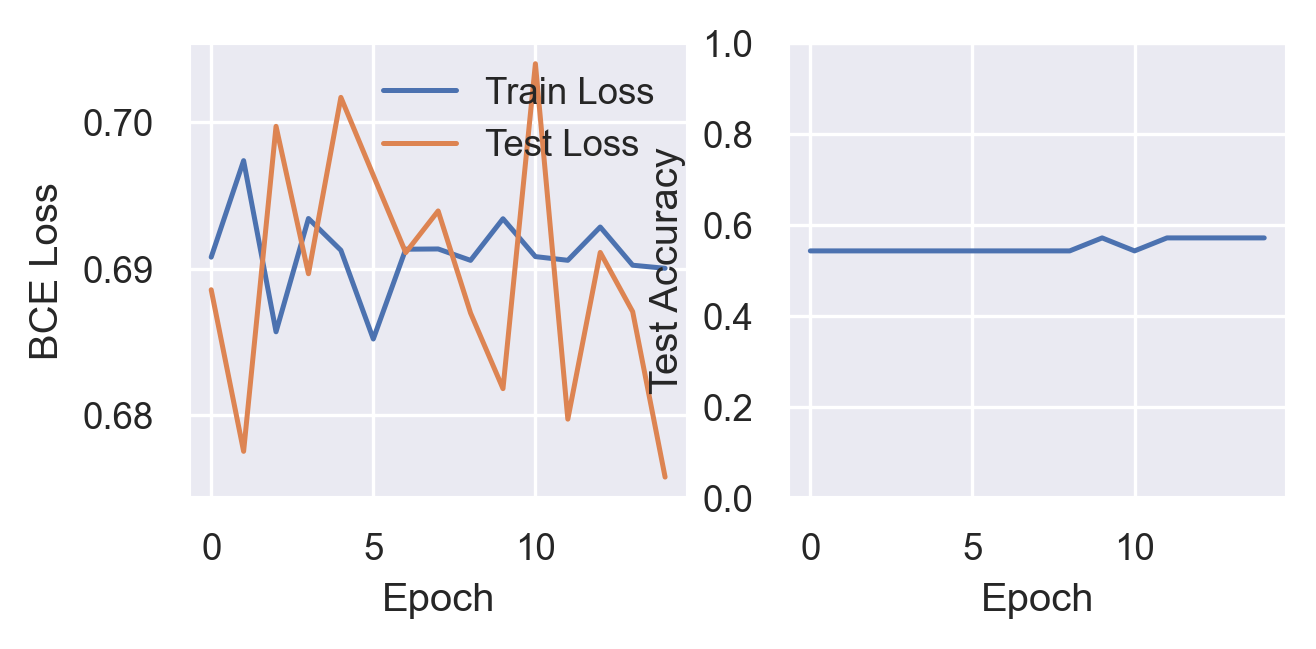

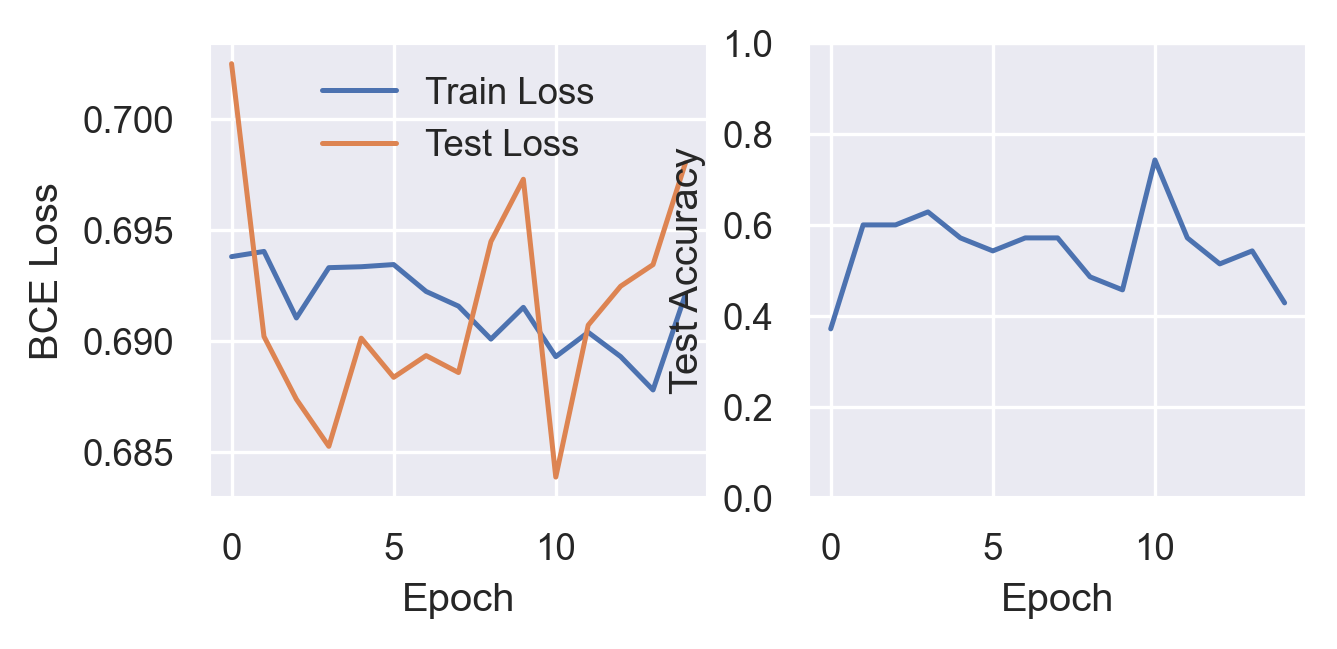

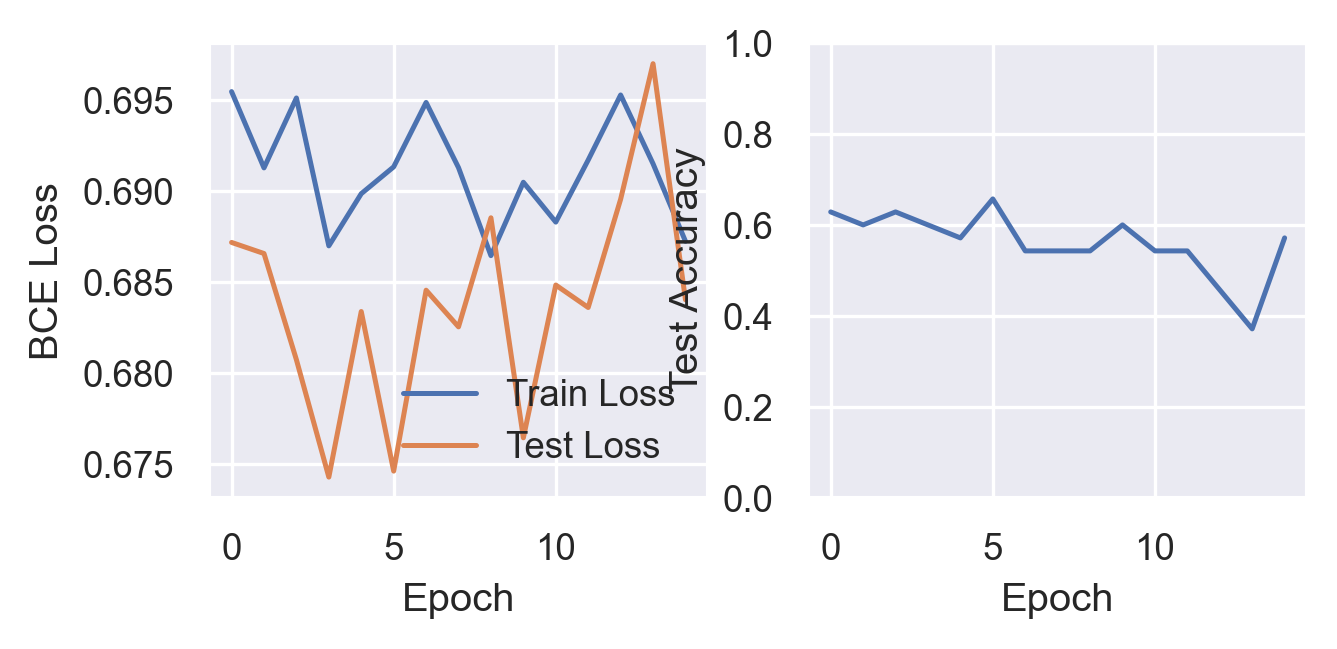

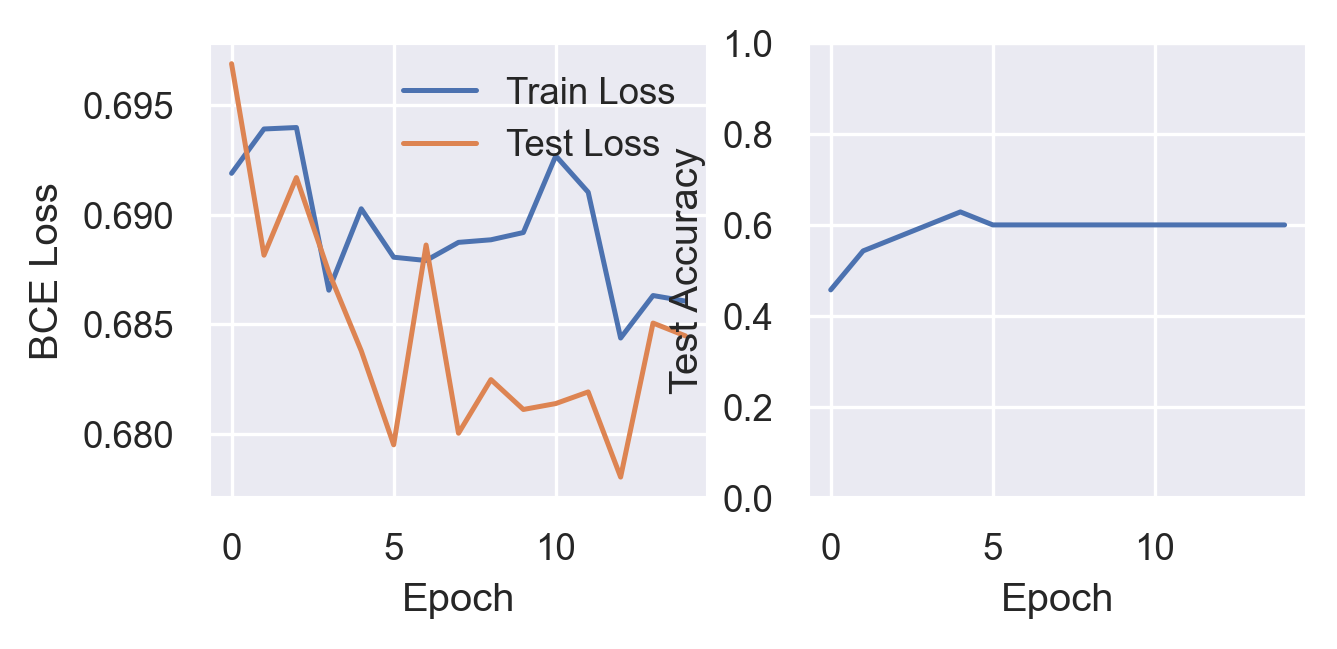

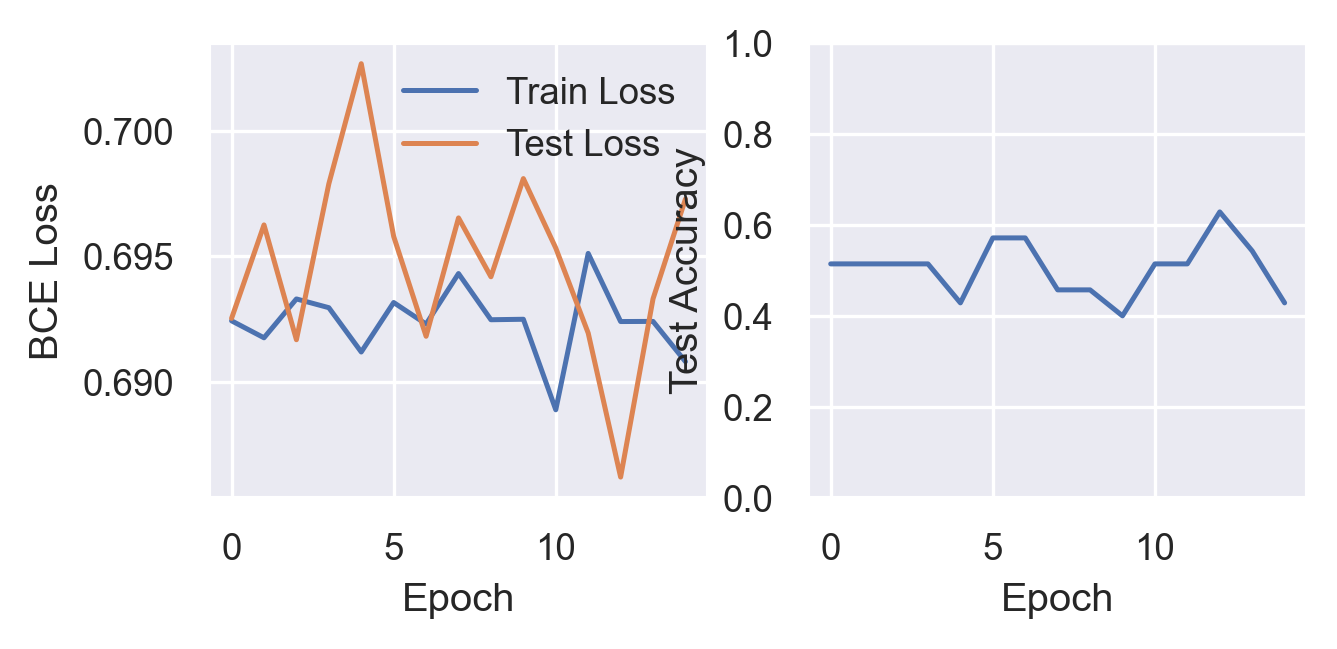

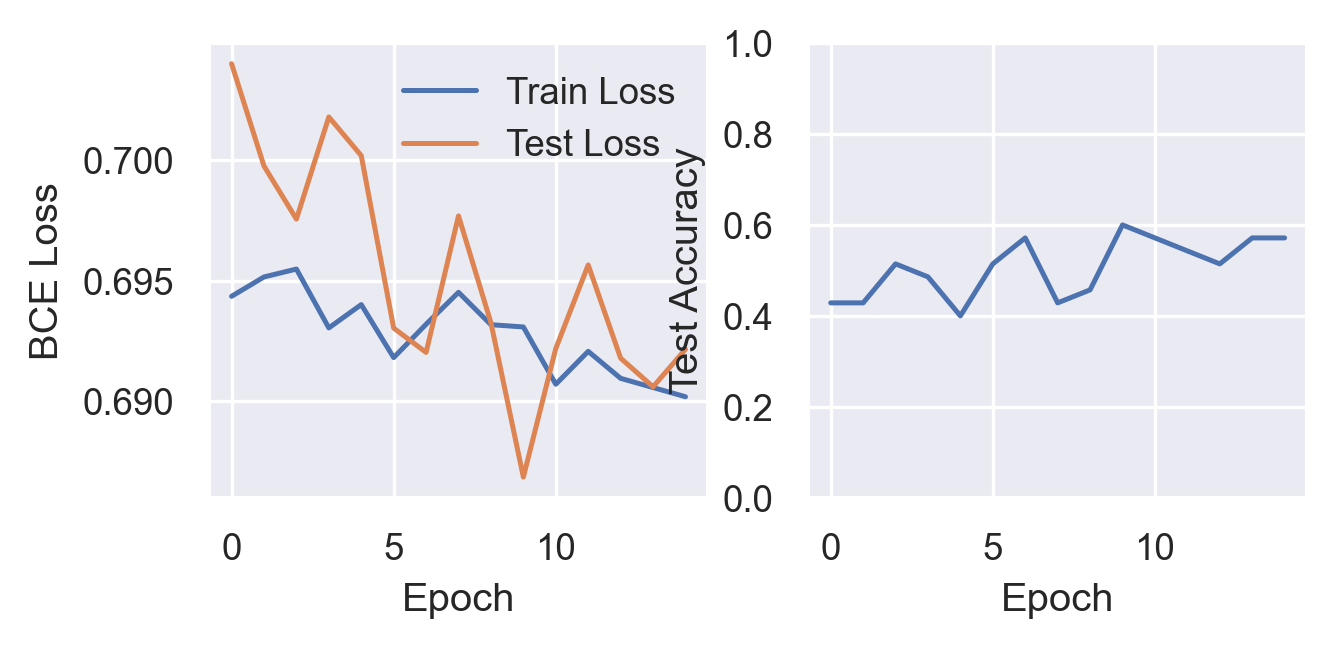

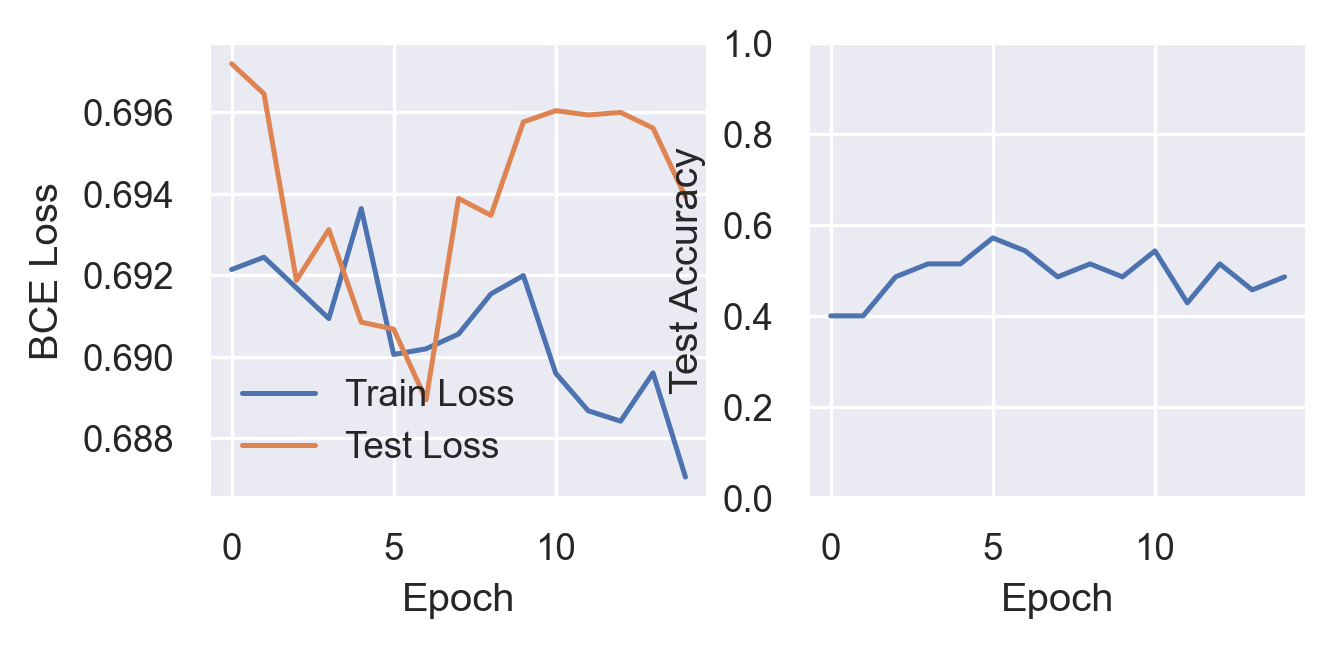

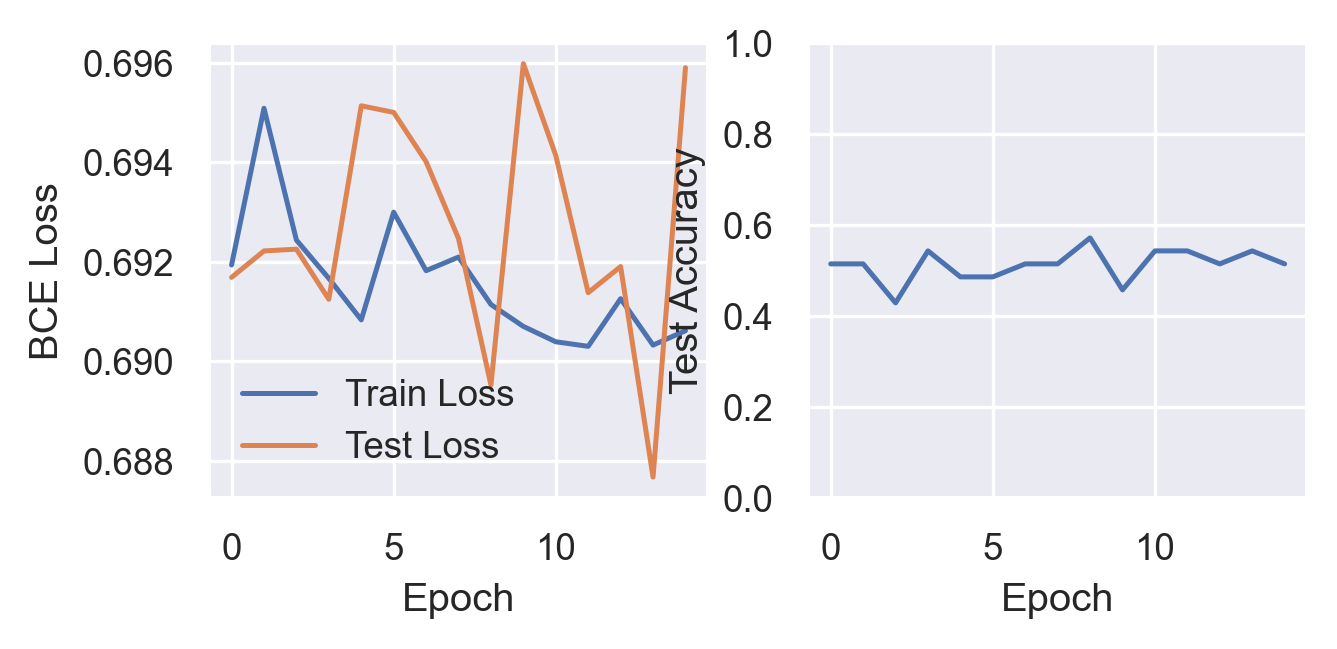

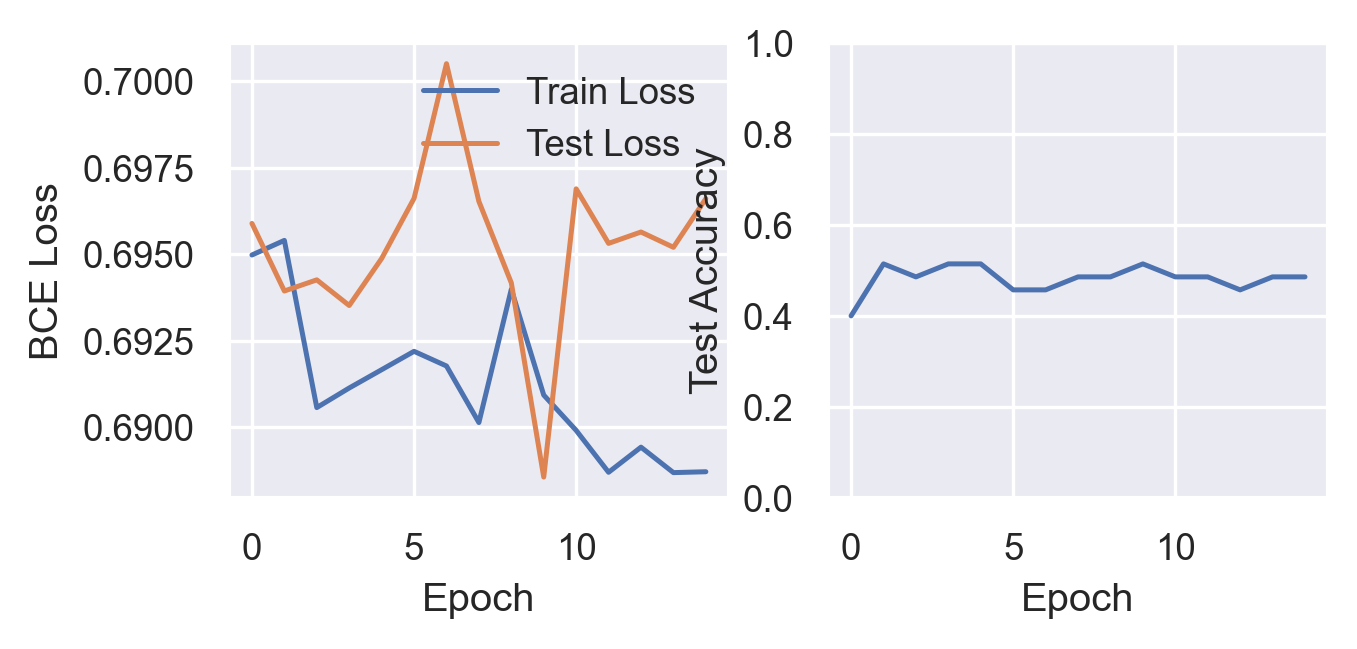

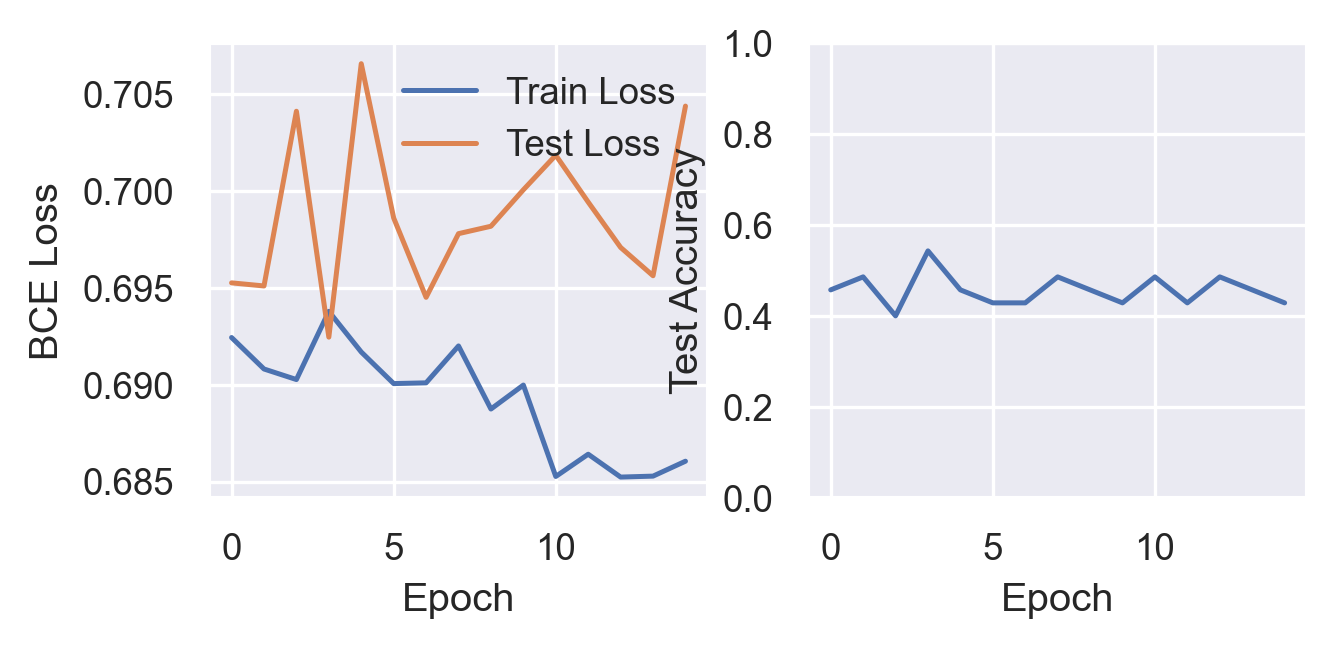

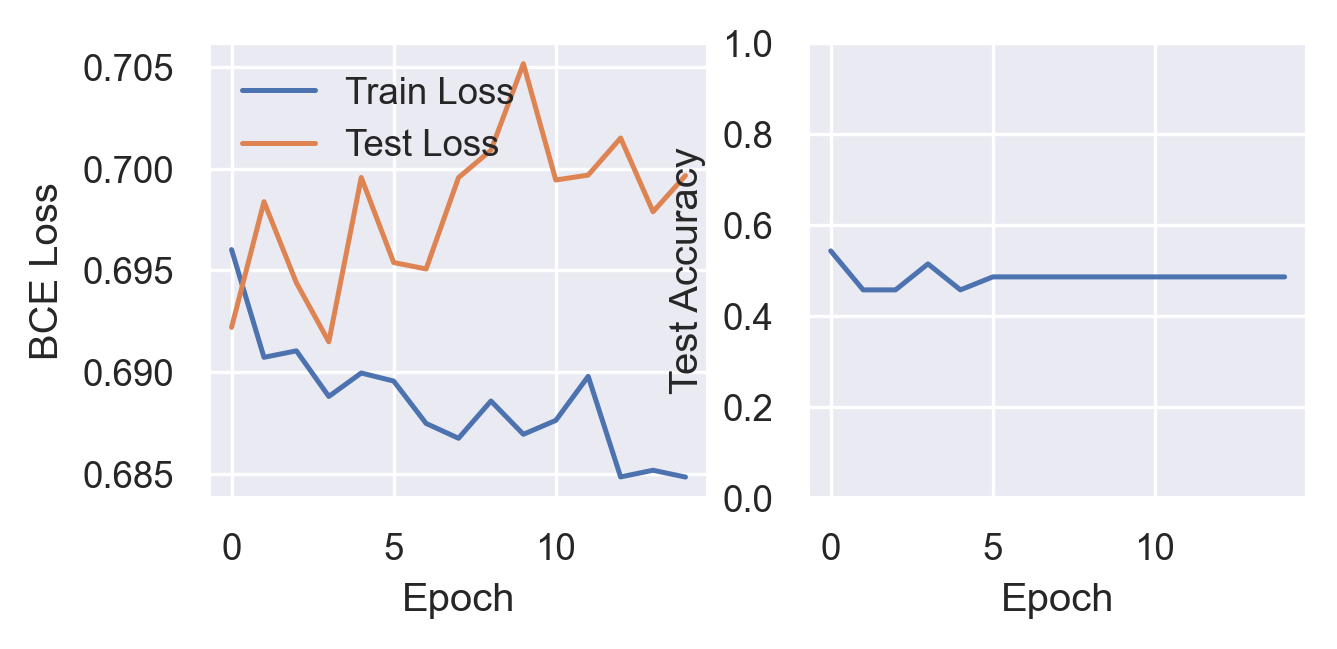

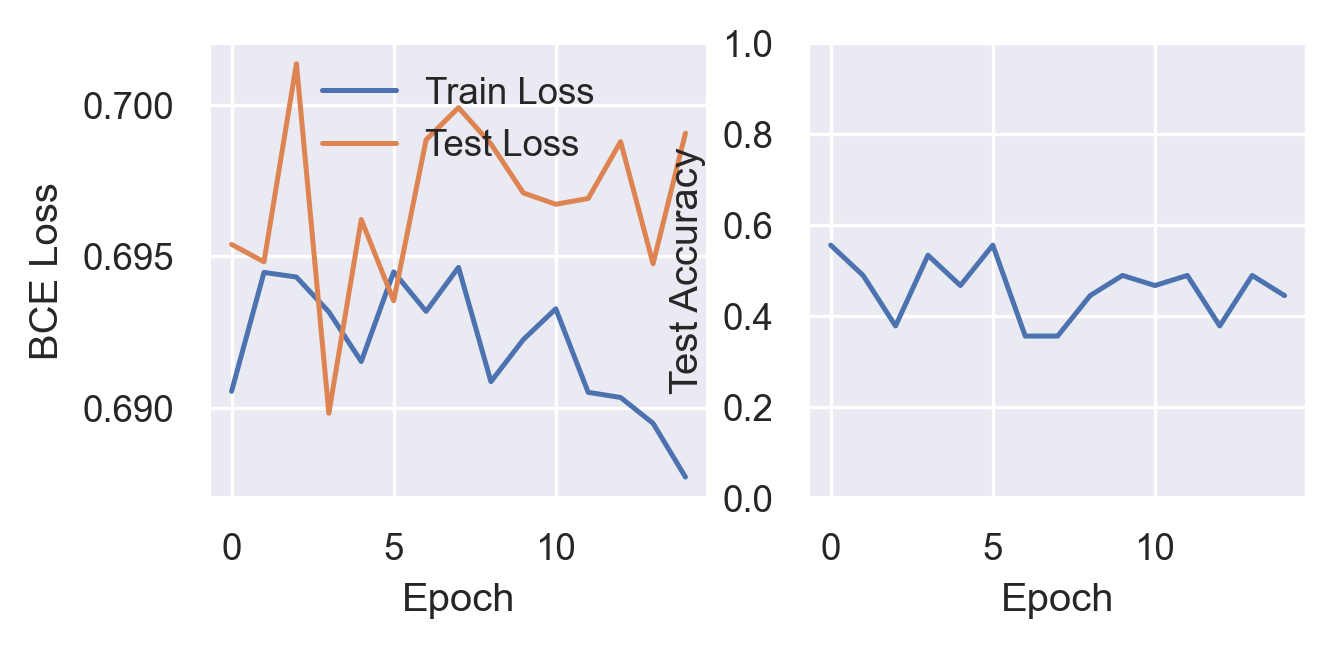

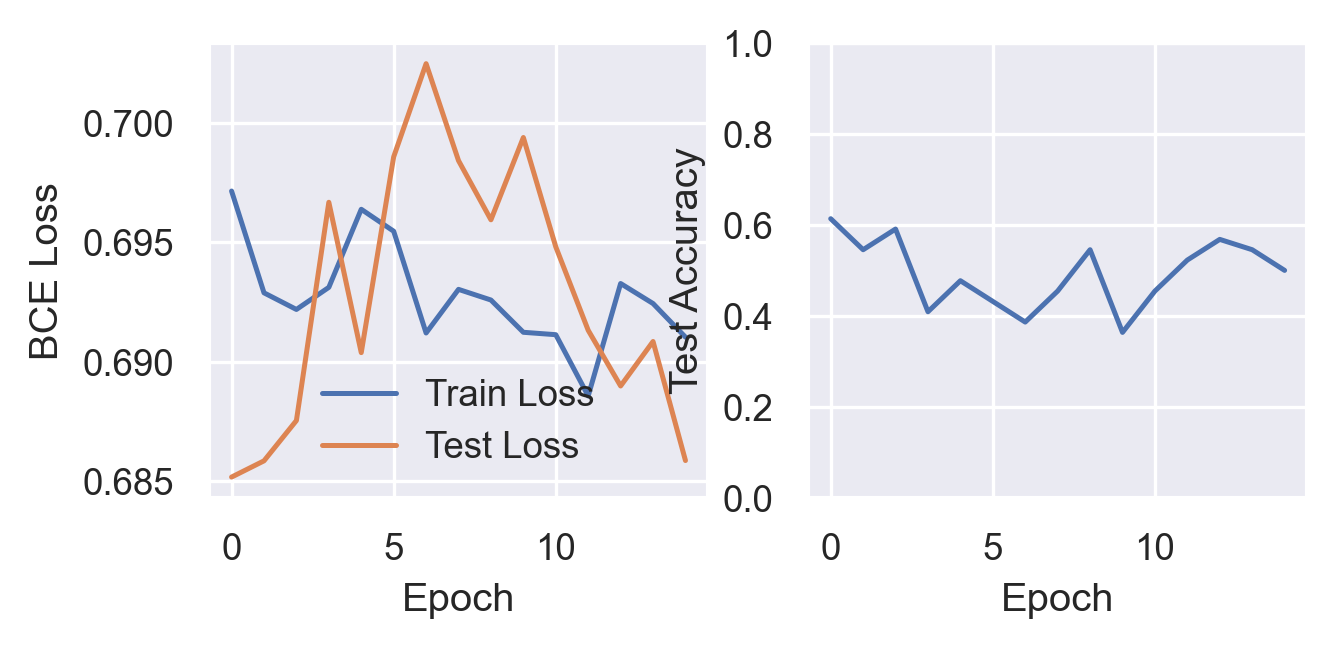

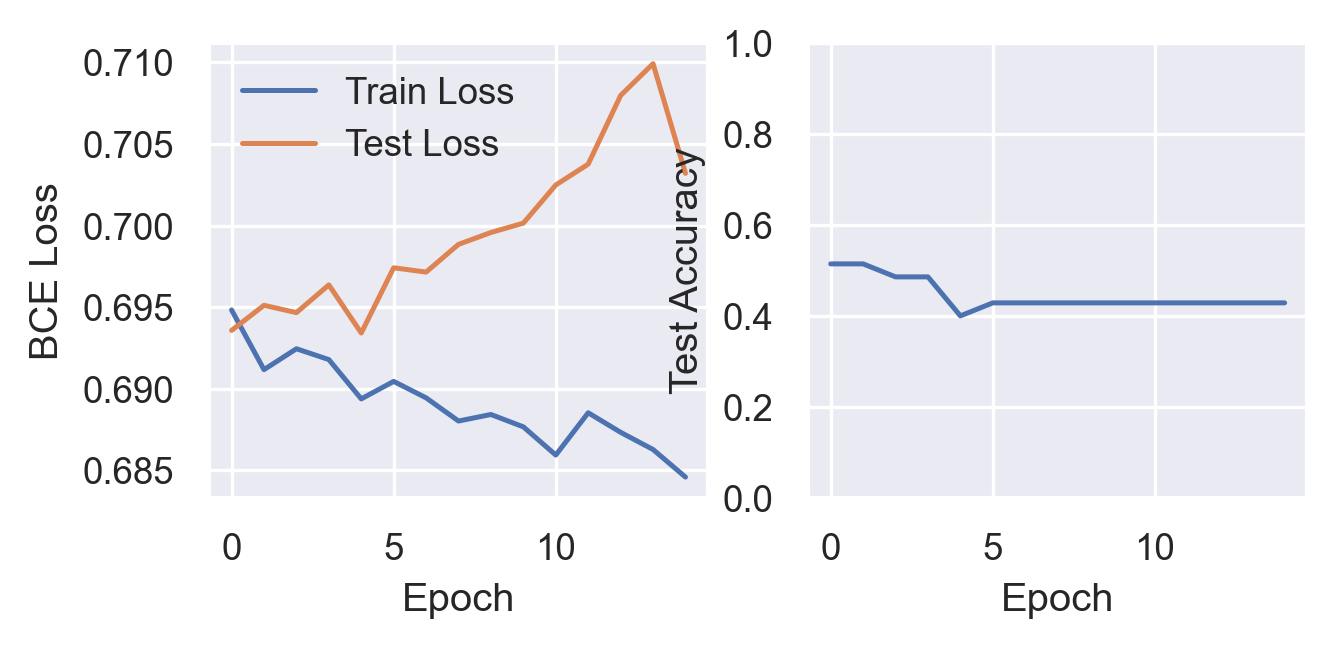

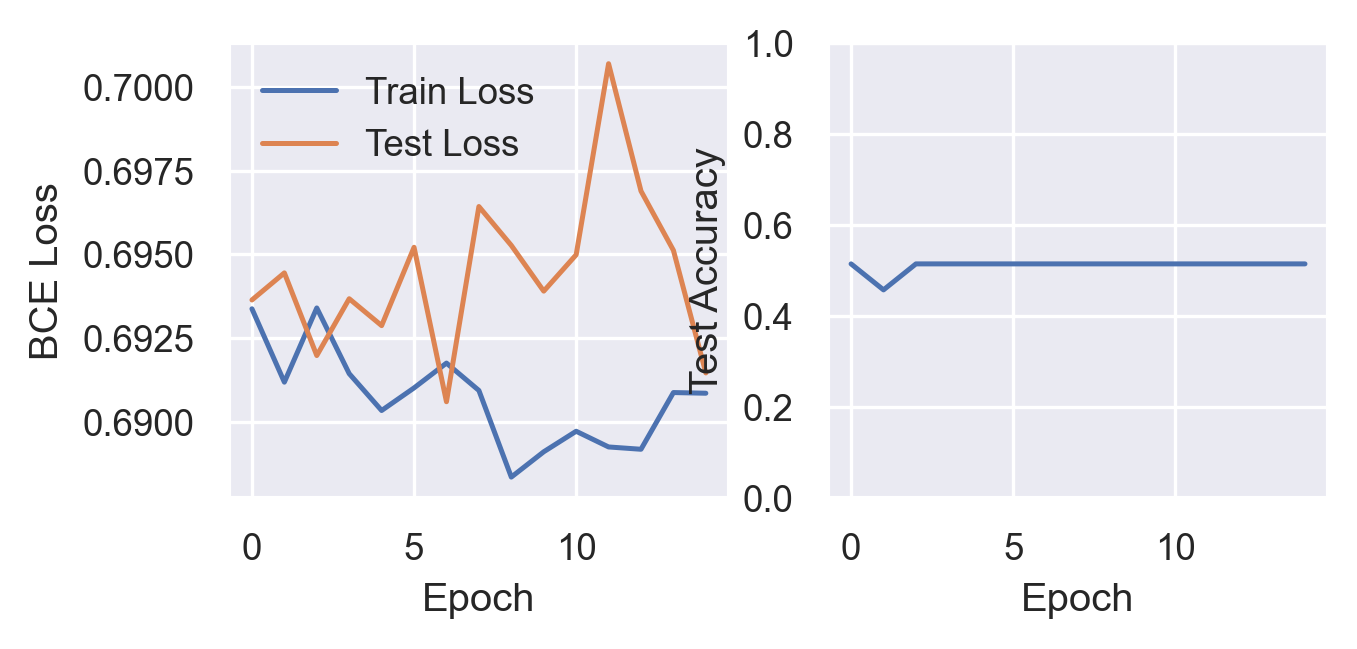

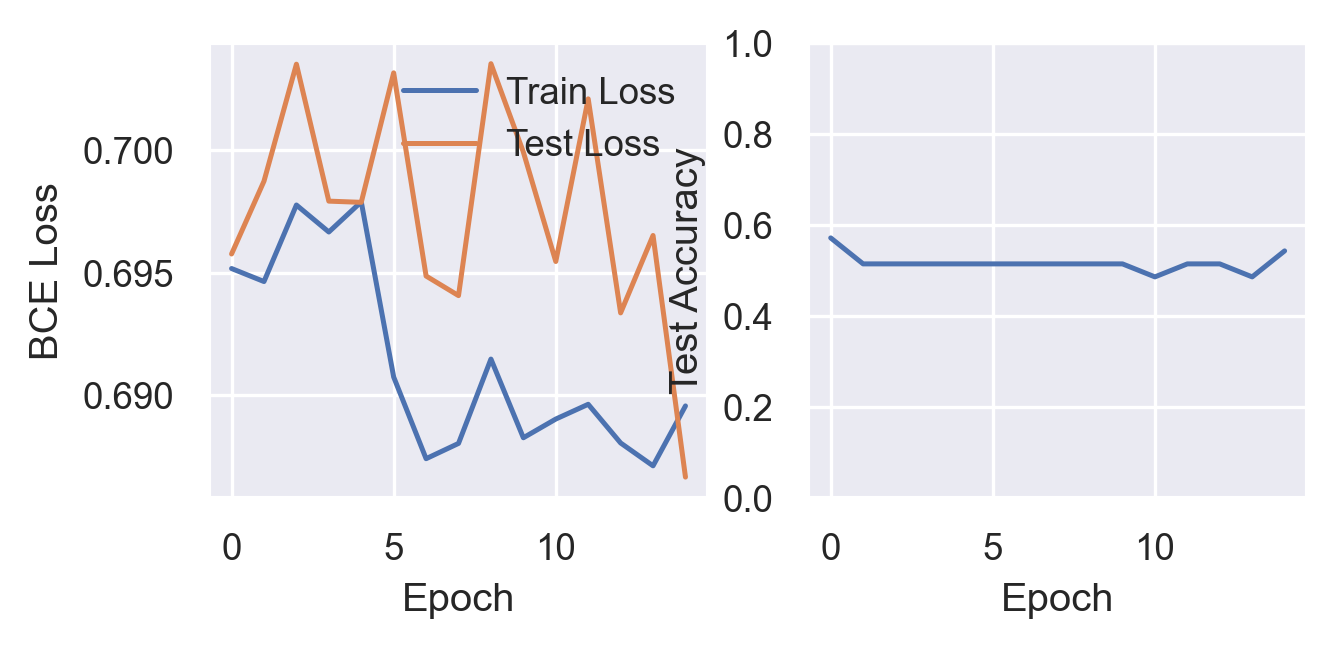

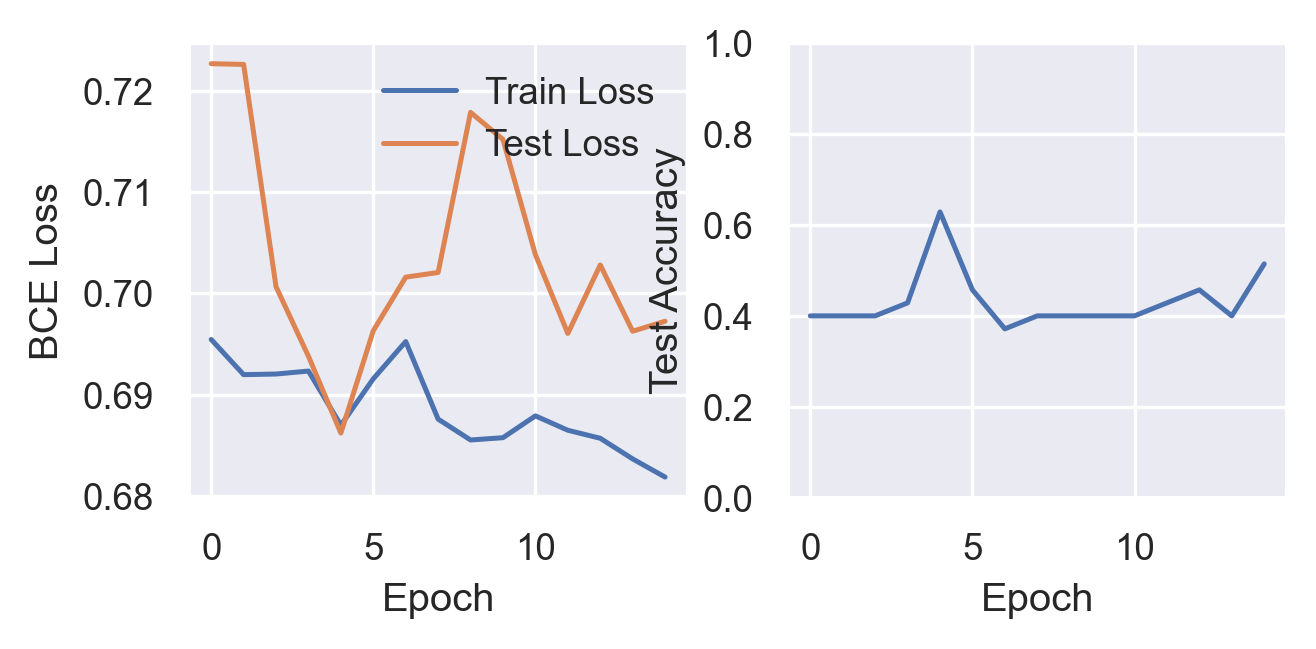

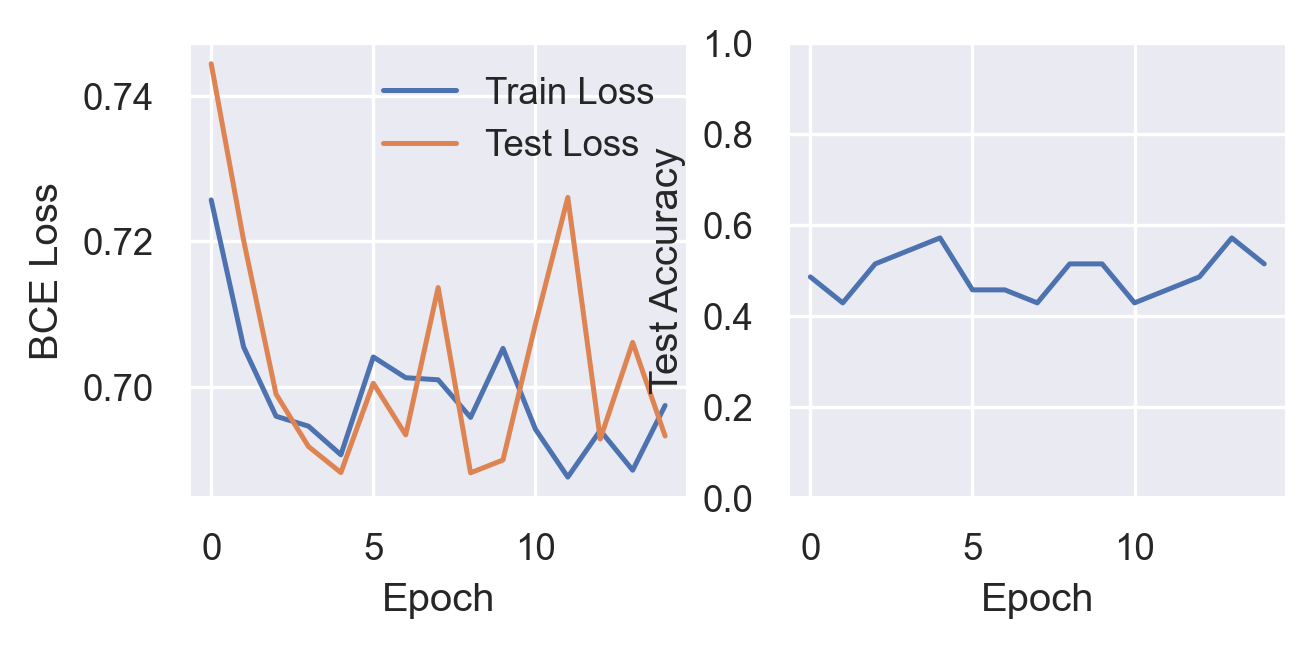

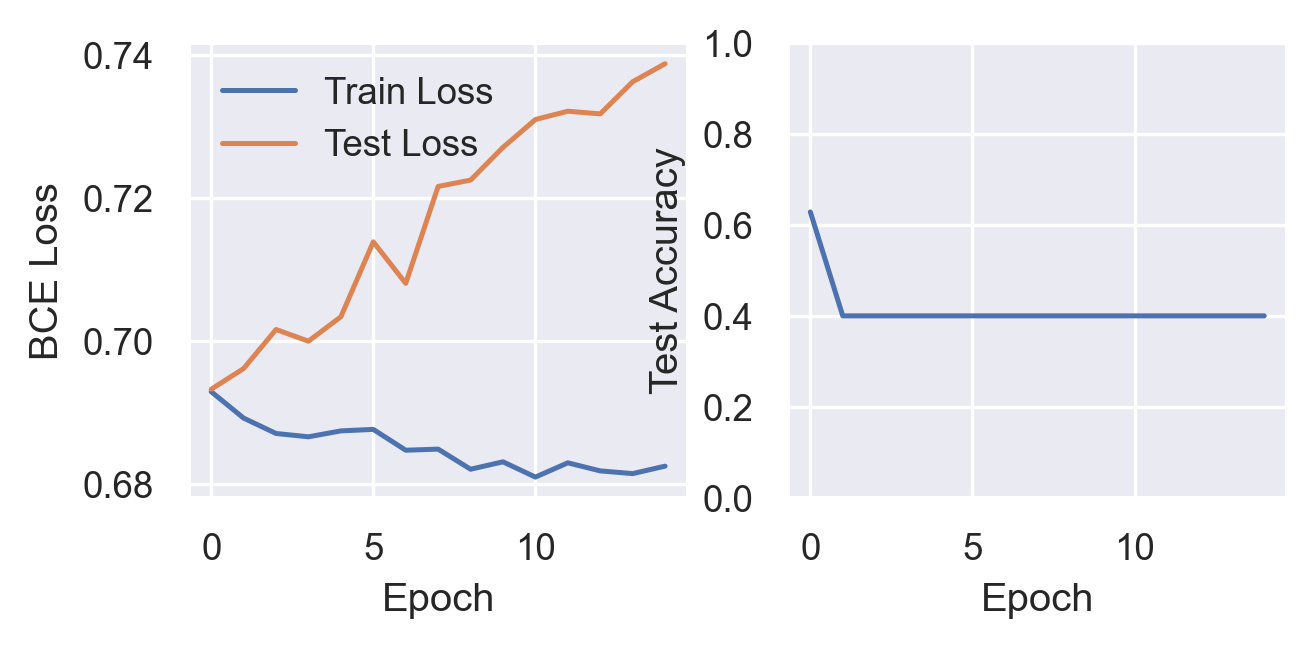

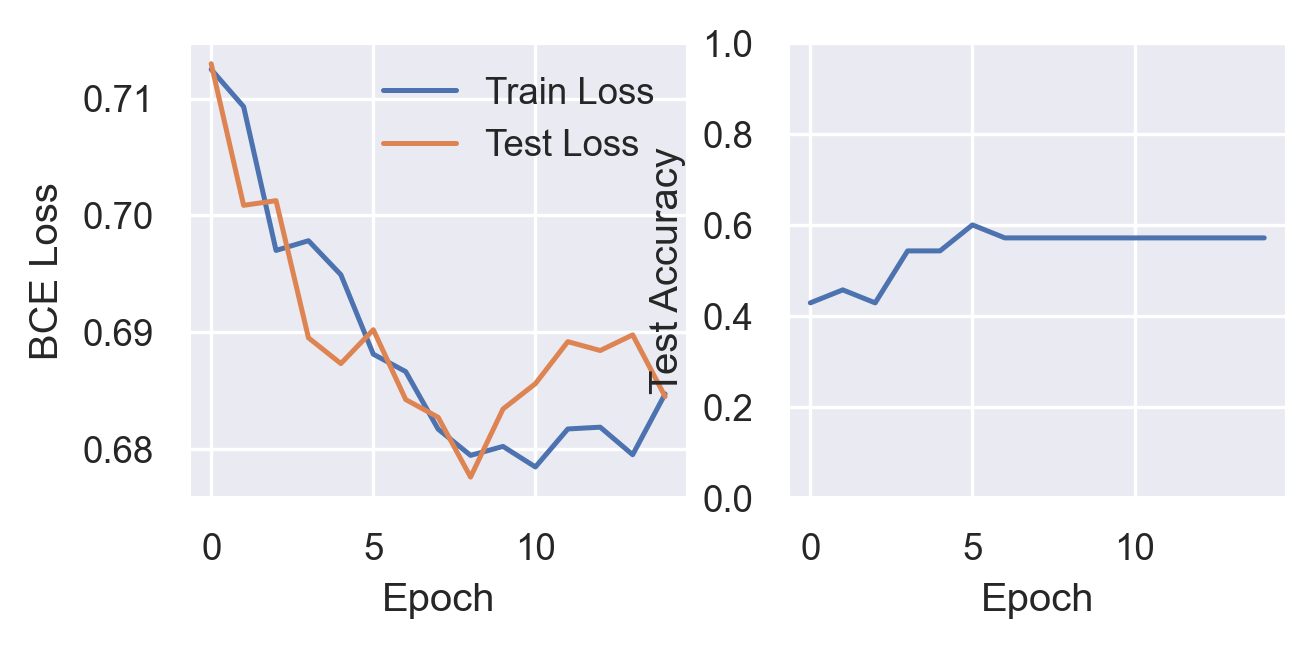

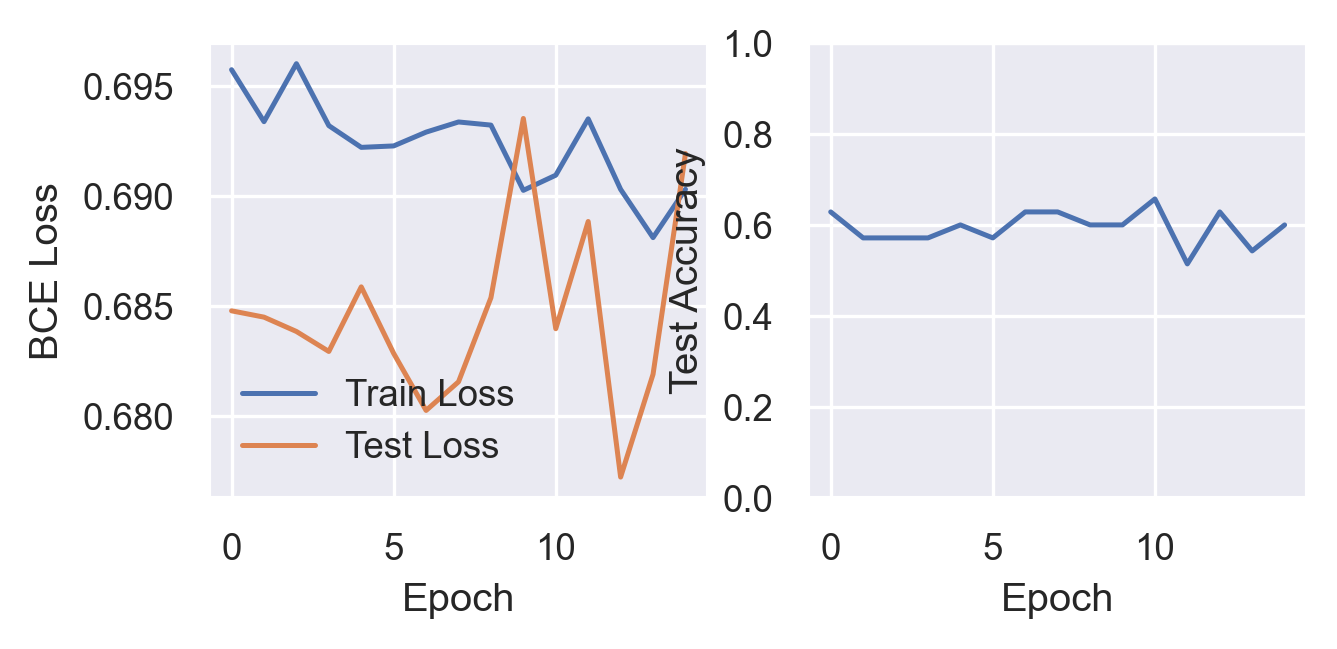

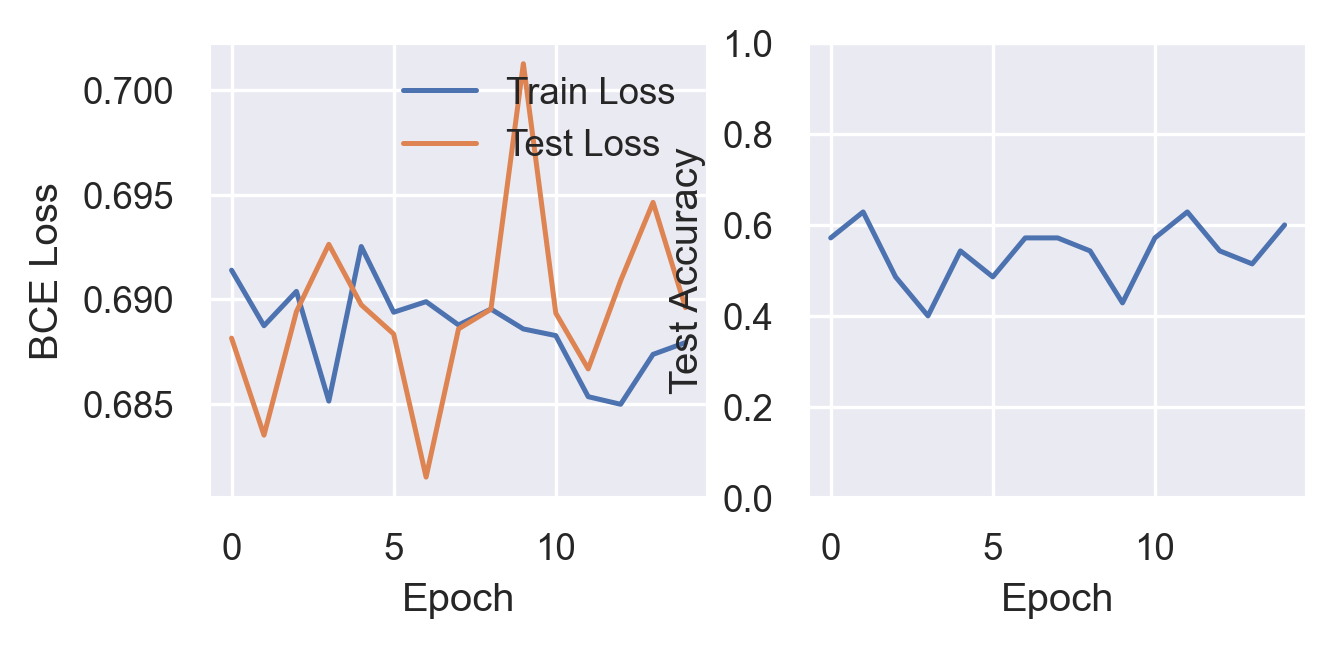

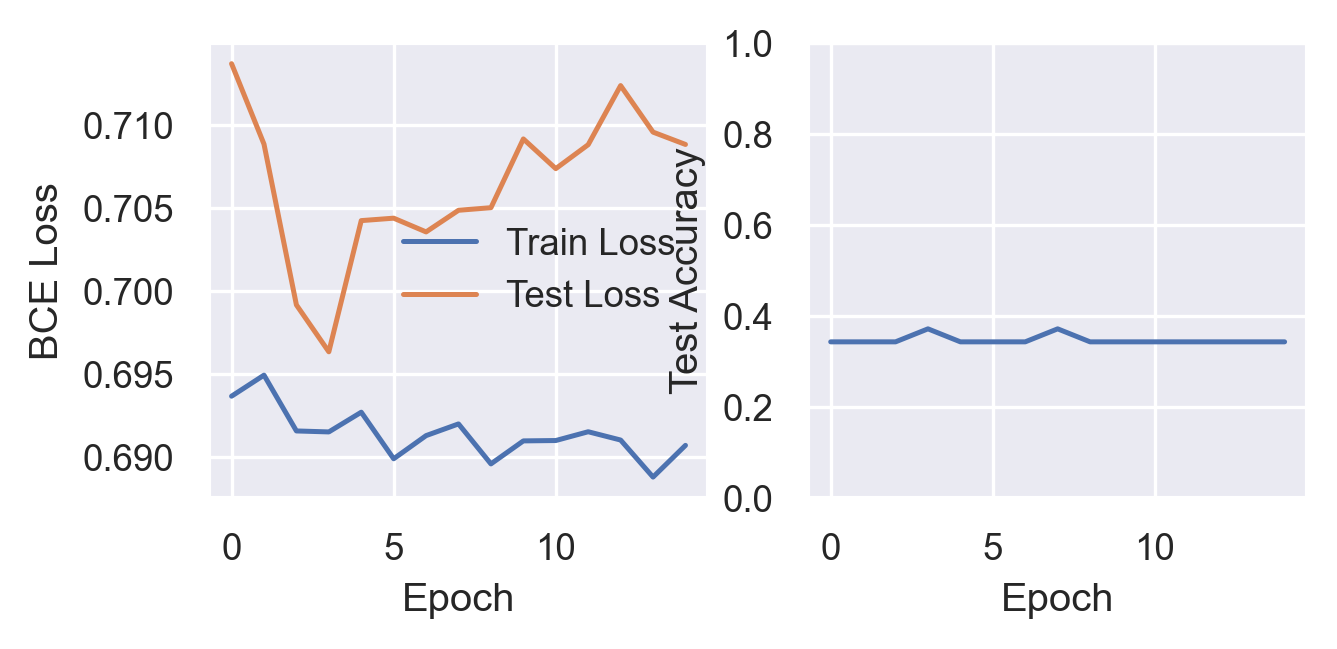

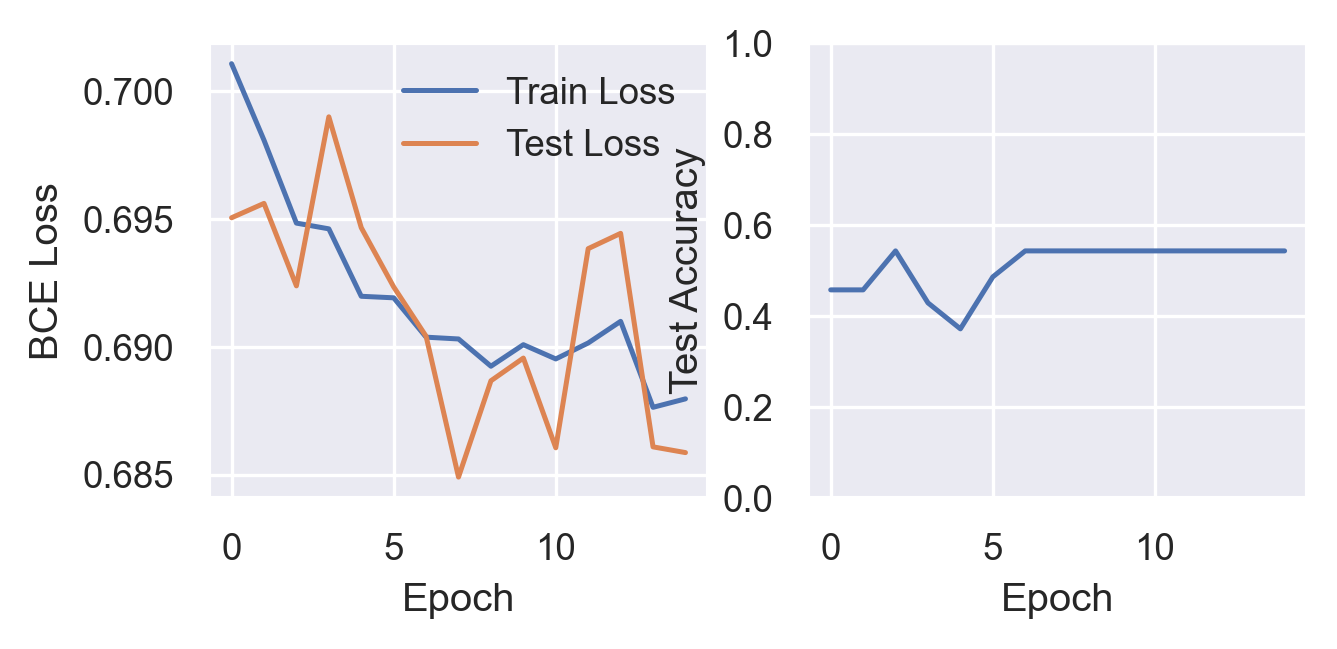

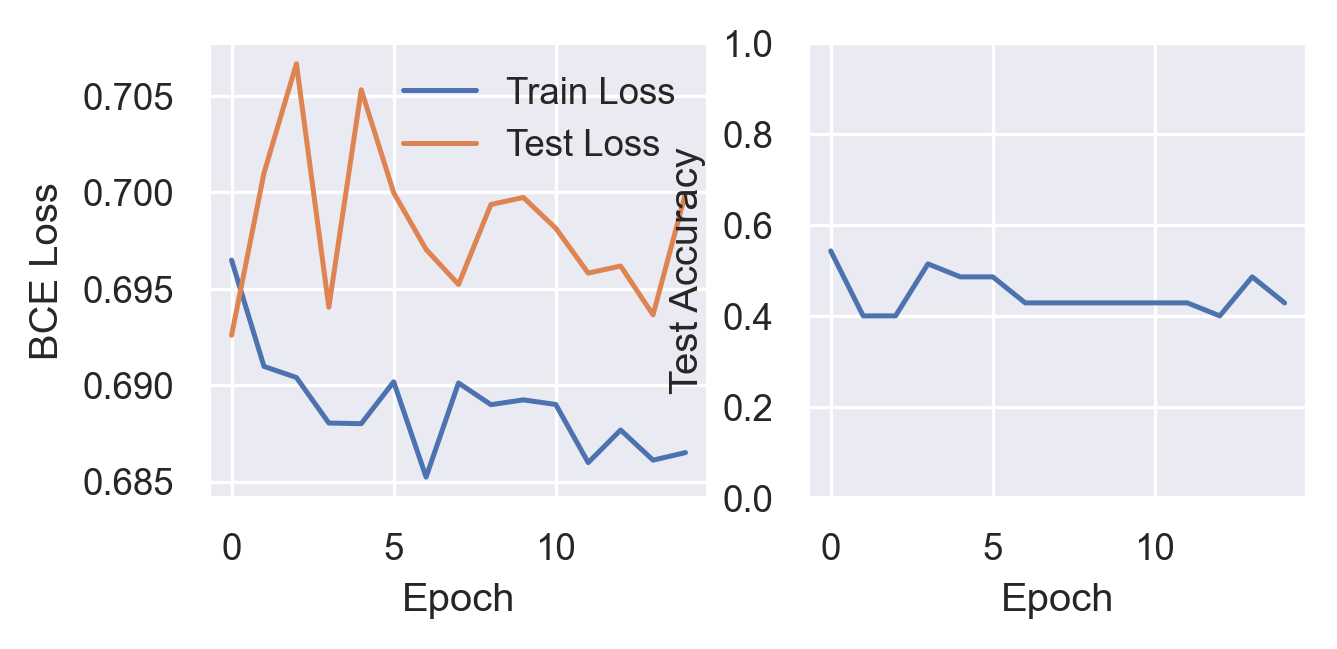

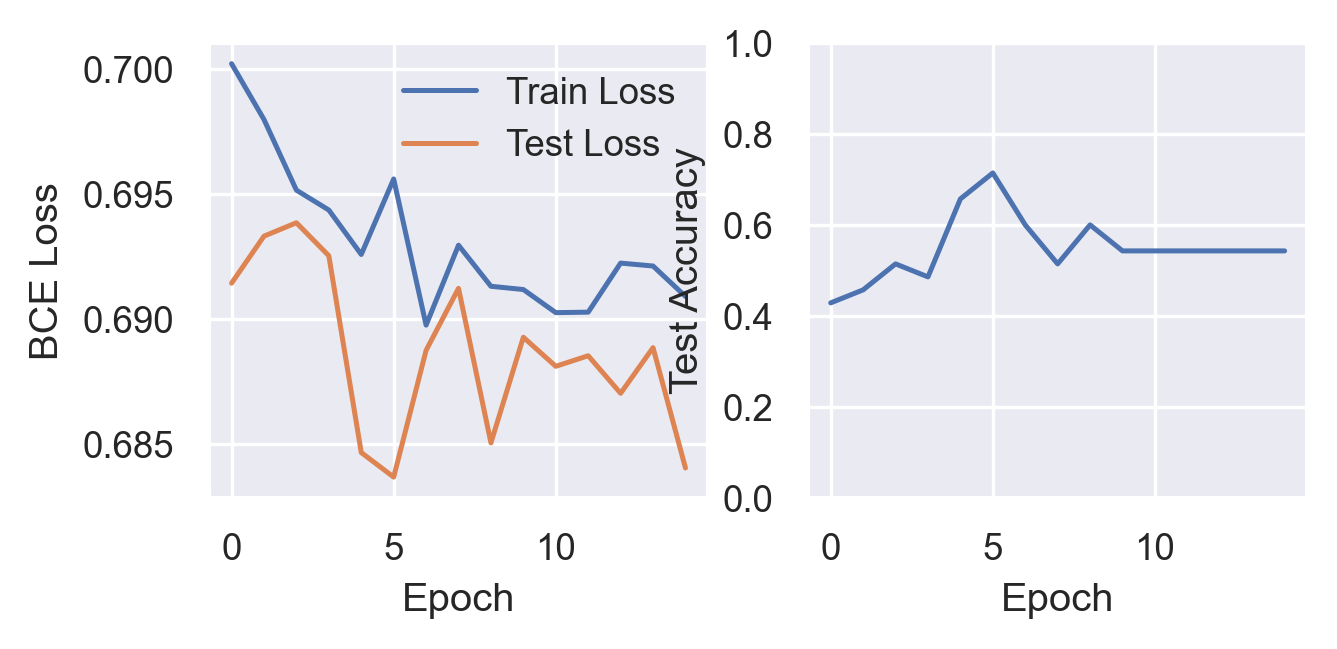

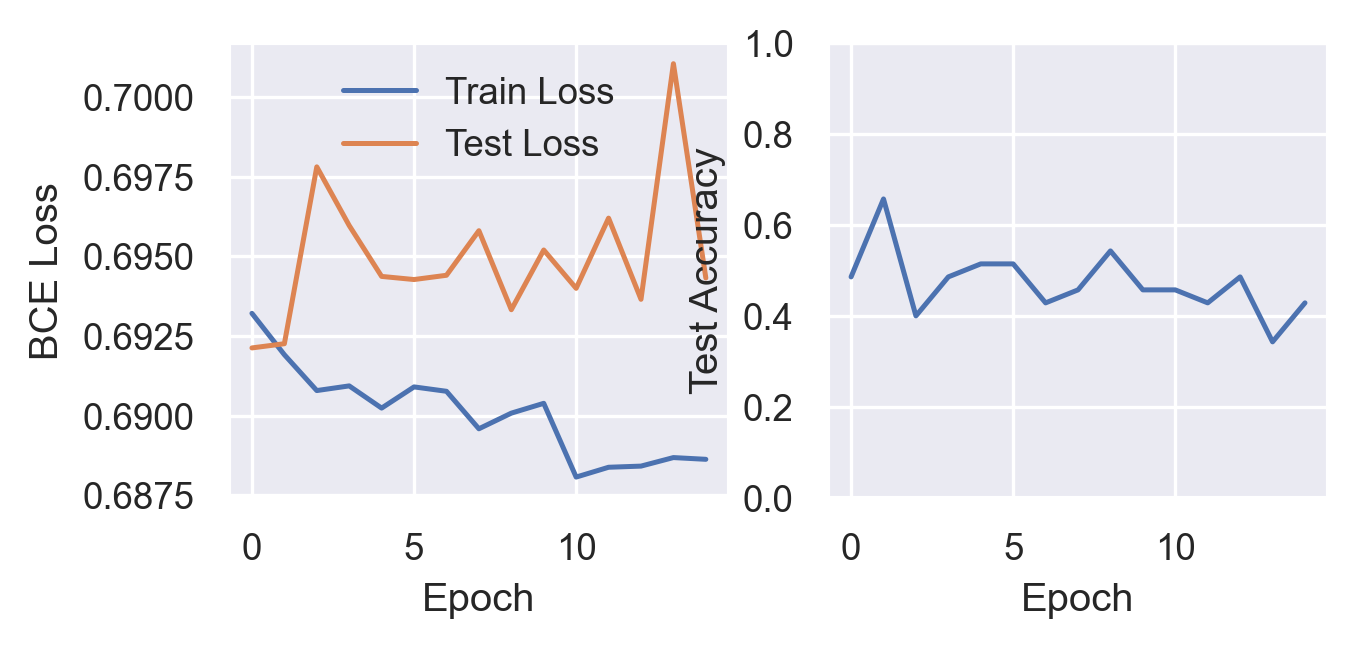

In [22]:
bjs = [10,20,30,50]
nspsins = [10,20,30]
directories = ["data/10x1", "data/20x1", "data/30x1"]
hiddens = [4,8,16,32]
embeddings = [1,2,3,4,5,6,7,8,9,10]
for BJ in bjs:
    #generate data for different spin size systems
    for i in range(len(nspsins)):
        N_spins = nspsins[i]
        directory = directories[i]
        N_hidden = 8
        N_embedding = 4
        createAndTrainNetwork(directory,N_spins,BJ,N_hidden, N_embedding)
    #generate data for different hidden sizes:
    for N_hidden in hiddens:
        N_spins = 10
        directory = "data/10x1"
        N_embedding = 4
        createAndTrainNetwork(directory,N_spins,BJ,N_hidden, N_embedding)
    #generate data for different embedding sizes
    for N_embedding in embeddings:
        N_spins = 10
        directory = "data/10x1"
        N_hidden = 8
        createAndTrainNetwork(directory,N_spins,BJ,N_hidden, N_embedding)

